# Recommender Systems

An Investigation for IBM Machine Learning Professional Certificate

Import Necessary Libraries

In [1]:
# ------------- EDA + Feature Engineering ------------- #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import TfidfModel, Word2Vec

# ------------- Content Based Recommender ------------- #
from sklearn.metrics.pairwise import cosine_similarity
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

Set Random State for Reproducibility

In [2]:
rs = 123

# Exploratory Data Analysis

### Load Dataset


In [3]:
# get dataset urls
course_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_genre.csv"
ratings_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"

In [4]:
# read to pandas dataframe
course_df = pd.read_csv(course_genre_url)
ratings_df = pd.read_csv(ratings_url)

We will start by exploring the course genre dataset. Let's first check its columns/features name:


In [5]:
# check columns in dataset
print(course_df.columns)

# check unique IDs of courses
course_df.shape[0]

Index(['COURSE_ID', 'TITLE', 'Database', 'Python', 'CloudComputing',
       'DataAnalysis', 'Containers', 'MachineLearning', 'ComputerVision',
       'DataScience', 'BigData', 'Chatbot', 'R', 'BackendDev', 'FrontendDev',
       'Blockchain'],
      dtype='object')


307

Check Samples & Types

In [6]:
# check data types
print(course_df.dtypes)

# check samples
course_df.head()

COURSE_ID          object
TITLE              object
Database            int64
Python              int64
CloudComputing      int64
DataAnalysis        int64
Containers          int64
MachineLearning     int64
ComputerVision      int64
DataScience         int64
BigData             int64
Chatbot             int64
R                   int64
BackendDev          int64
FrontendDev         int64
Blockchain          int64
dtype: object


COURSE_ID                                              TITLE  Database  \
0    ML0201EN  robots are coming  build iot apps with watson ...         0   
1    ML0122EN                accelerating deep learning with gpu         0   
2  GPXX0ZG0EN  consuming restful services using the reactive ...         0   
3    RP0105EN         analyzing big data in r using apache spark         1   
4  GPXX0Z2PEN  containerizing  packaging  and running a sprin...         0   

   Python  CloudComputing  DataAnalysis  Containers  MachineLearning  \
0       0               0             0           0                0   
1       1               0             0           0                1   
2       0               0             0           0                0   
3       0               0             1           0                0   
4       0               0             0           1                0   

   ComputerVision  DataScience  BigData  Chatbot  R  BackendDev  FrontendDev  \
0               0            0        0        0  0           1            1   
1               0            1        0        0  0           0            0   
2               0            0        0        0  0           1            1   
3               0            0        1        0  1           0            0   
4               0            0        0        0  0           1            0   

   Blockchain  
0           0  
1           0  
2           0  
3           0  
4           0

All int64, except for Course_ID and Title, which are strings.

### Creating Word Cloud for Titles


In [7]:
# join title values as one string
titles = " ".join(title for title in course_df['TITLE'].astype(str))

titles

'robots are coming  build iot apps with watson  swift  and node red accelerating deep learning with gpu consuming restful services using the reactive jax rs client analyzing big data in r using apache spark containerizing  packaging  and running a spring boot application cloud native security conference  data security data science bootcamp with r for university proffesors learn how to use docker containers for iterative development scorm test course create your first mongodb database testing microservices with the arquillian managed container cloud pak for integration essentials watson analytics for social media data science bootcamp with python for university professors  advance create a cryptocurrency trading algorithm in python data   ai essentials securing java microservices with eclipse microprofile json web token  microprofile jwt  enabling distributed tracing in microservices with zipkin sql access for hadoop ybrid cloud conference  ai pipelines lab dataops methodology data   ai

Remove stopwords

In [8]:
# stopwords from wordcloud
stopwords = set(STOPWORDS)

# update with common ones seen from inspection
stopwords.update(["getting started", "using", "enabling", "template", "university", "end", "introduction", "basic"])

In [9]:
# create wordcloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400)

In [10]:
wordcloud.generate(titles)

Plot Wordcloud

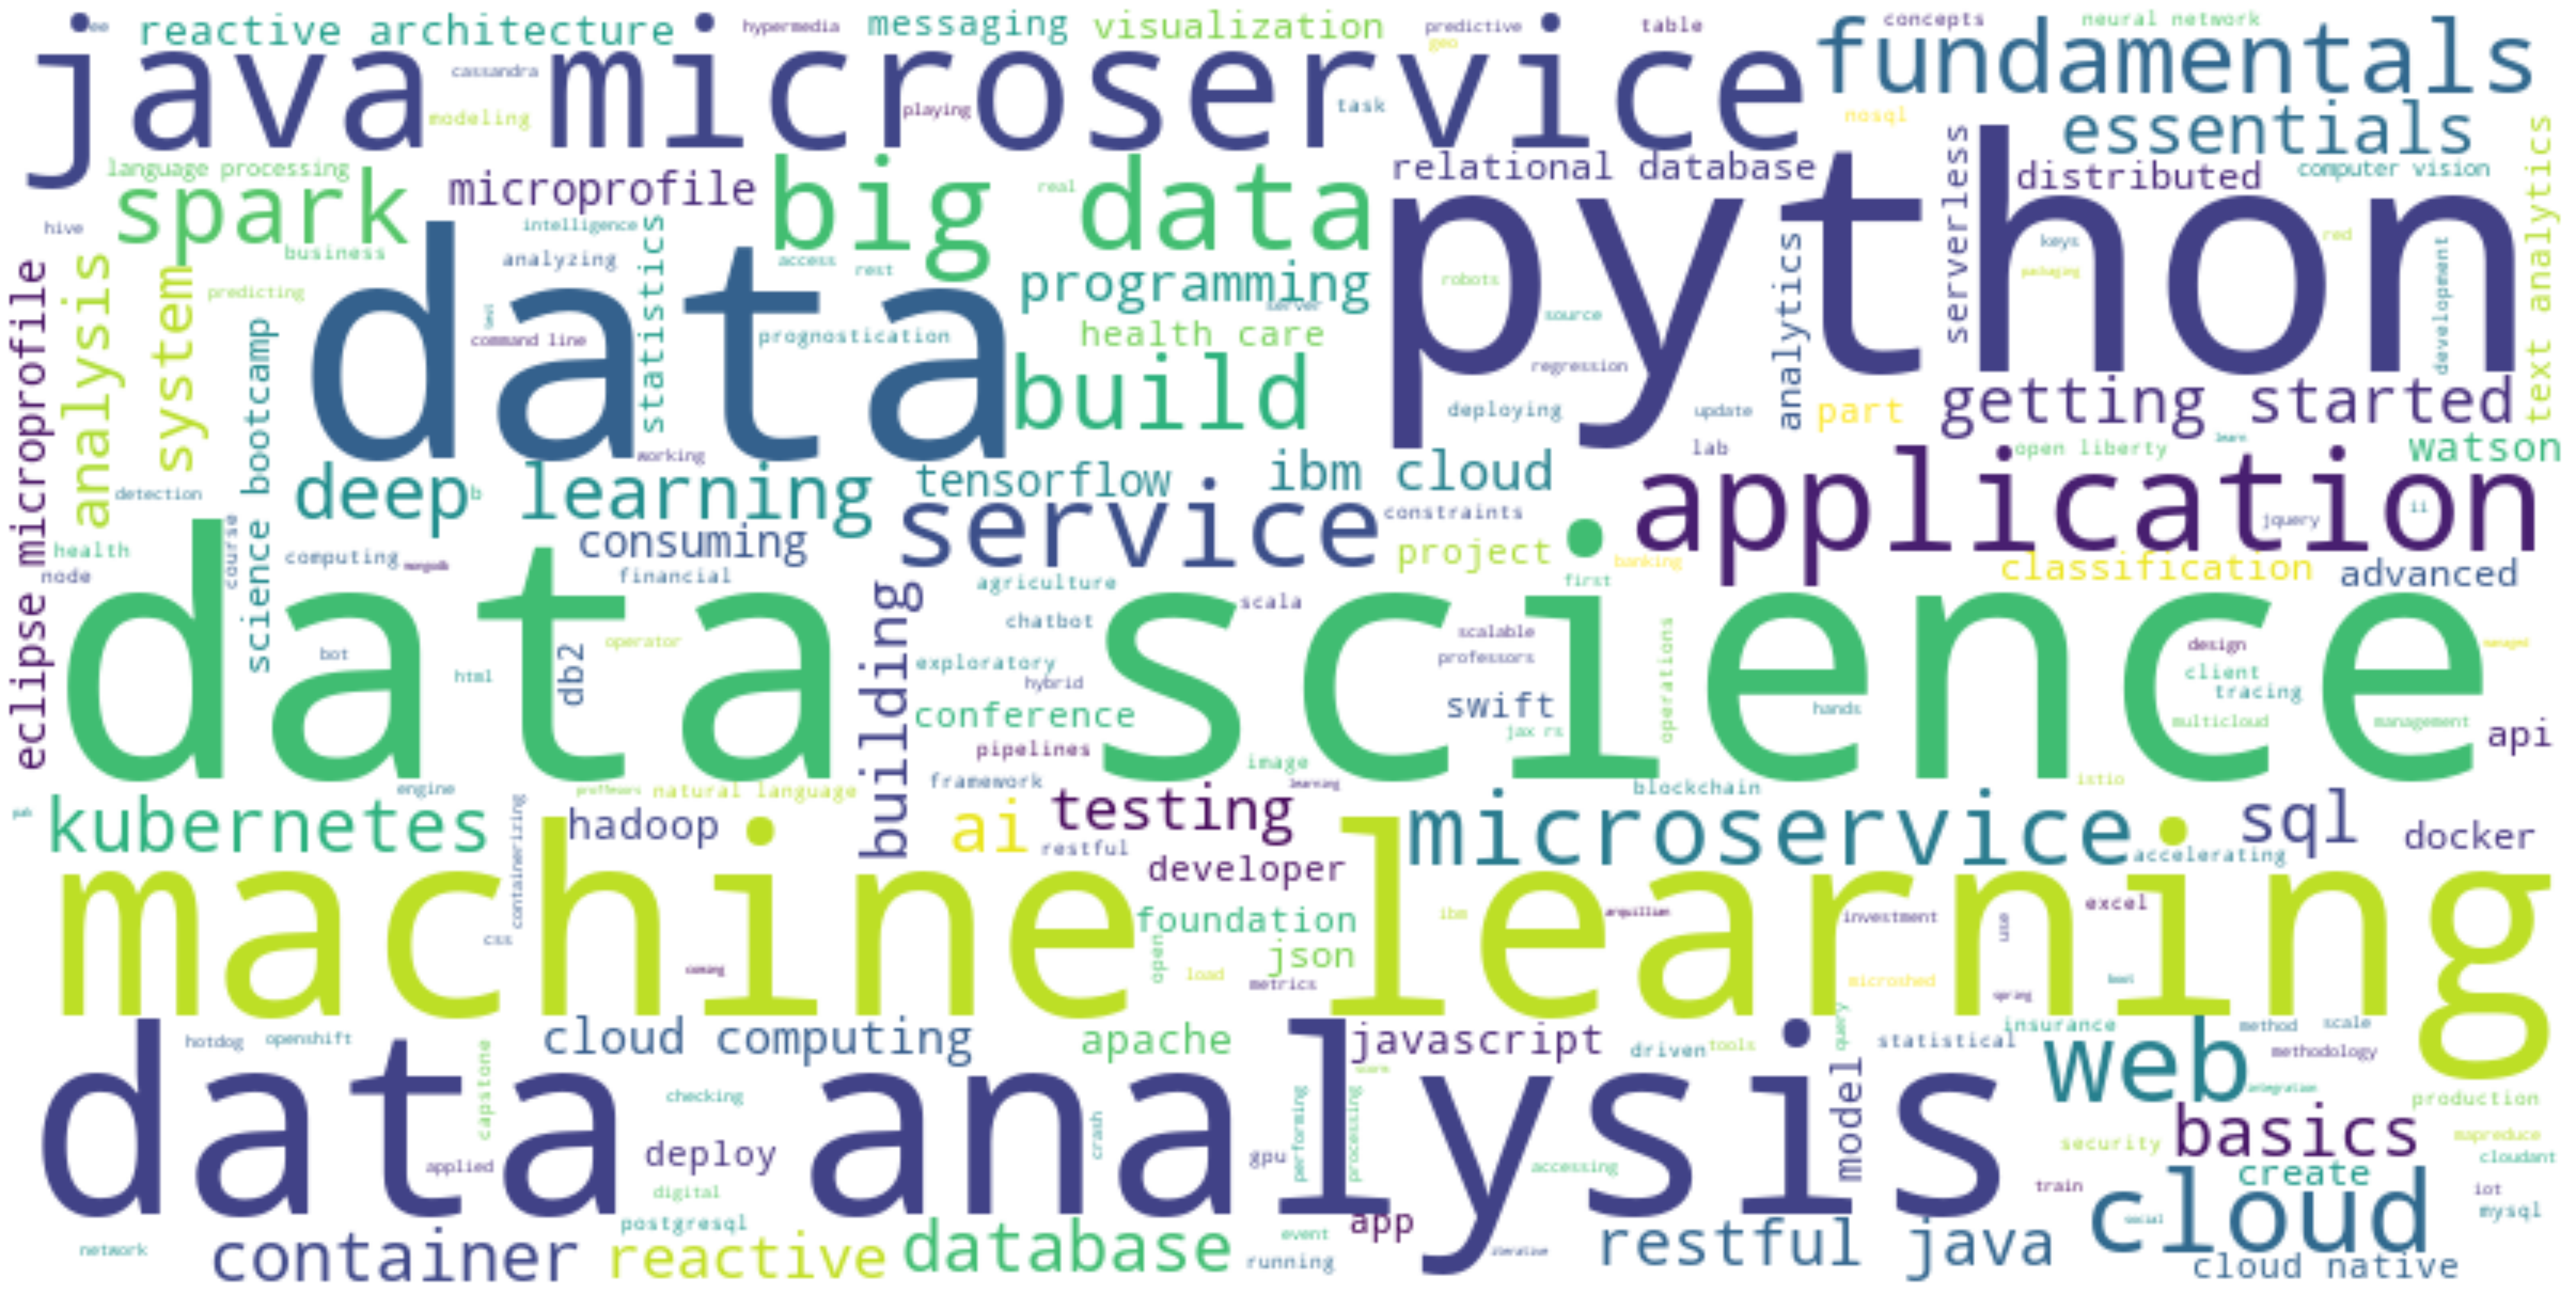

In [11]:
# plot wordcloud
plt.figure(figsize=(40,20))
plt.axis("off")
plt.tight_layout(pad=0)

# use bilinear interpolation for wordcloud
plt.imshow(wordcloud, interpolation="bilinear")

plt.show()

Many Comupter Science / Data Science related terms in the wordcloud, like python, data science, machine learning,  etc.

Explore Courses

In [12]:
# all machine learning related courses
machine_learning_courses = course_df[course_df["MachineLearning"] == 1]

machine_learning_courses

COURSE_ID                                              TITLE  Database  \
1      ML0122EN                accelerating deep learning with gpu         0   
15     DAI101EN                               data   ai essentials         0   
19     HCC105EN           ybrid cloud conference  ai pipelines lab         0   
21     DS0132EN                  data   ai  jumpstart your journey         0   
24     BENTEST4                 ai for everyone  master the basics         0   
..          ...                                                ...       ...   
274  excourse61        convolutional neural networks in tensorflow         0   
282  excourse69                     machine learning with big data         0   
290  excourse77  natural language processing with attention models         0   
291  excourse78   natural language processing with sequence models         0   
292  excourse79  natural language processing with probabilistic...         0   

     Python  CloudComputing  DataAnalysis  Containers  MachineLearning  \
1         1               0             0           0                1   
15        0               0             0           0                1   
19        0               0             0           0                1   
21        0               0             0           0                1   
24        0               0             0           0                1   
..      ...             ...           ...         ...              ...   
274       0               0             0           0                1   
282       0               0             0           0                1   
290       0               0             0           0                1   
291       0               0             0           0                1   
292       0               0             0           0                1   

     ComputerVision  DataScience  BigData  Chatbot  R  BackendDev  \
1                 0            1        0        0  0           0   
15                0            0        0        0  0           0   
19                0            0        0        0  0           0   
21                0            0        0        0  0           0   
24                0            0        0        0  0           0   
..              ...          ...      ...      ... ..         ...   
274               1            0        0        0  0           0   
282               0            0        1        0  0           0   
290               0            0        0        0  0           0   
291               0            0        0        0  0           0   
292               0            0        0        0  0           0   

     FrontendDev  Blockchain  
1              0           0  
15             0           0  
19             0           0  
21             0           0  
24             0           0  
..           ...         ...  
274            0           0  
282            0           0  
290            0           0  
291            0           0  
292            0           0  

[69 rows x 16 columns]

In [13]:
# machine learning and big data courses
machine_learning_big_data_courses = course_df[(course_df["MachineLearning"] == 1) & (course_df["BigData"] == 1)]

machine_learning_big_data_courses

COURSE_ID                                              TITLE  Database  \
46   GPXX0BUBEN  insurance risk assessment with montecarlo meth...         0   
59     TA0106EN                            text analytics at scale         0   
184    BD0221EN                                        spark mllib         0   
282  excourse69                     machine learning with big data         0   

     Python  CloudComputing  DataAnalysis  Containers  MachineLearning  \
46        0               0             0           0                1   
59        0               0             0           0                1   
184       0               0             0           0                1   
282       0               0             0           0                1   

     ComputerVision  DataScience  BigData  Chatbot  R  BackendDev  \
46                0            0        1        0  0           0   
59                0            1        1        0  0           0   
184               0            0        1        0  0           0   
282               0            0        1        0  0           0   

     FrontendDev  Blockchain  
46             0           0  
59             0           0  
184            0           0  
282            0           0

In [14]:
# look at genre options
genres = course_df.columns[2:]

genres

Index(['Database', 'Python', 'CloudComputing', 'DataAnalysis', 'Containers',
       'MachineLearning', 'ComputerVision', 'DataScience', 'BigData',
       'Chatbot', 'R', 'BackendDev', 'FrontendDev', 'Blockchain'],
      dtype='object')

Counting How Many Courses for Each Genre

In [15]:
# sum genres
genre_totals = course_df[genres].sum().sort_values(ascending=False)

print(genre_totals)

BackendDev         78
MachineLearning    69
Database           60
DataAnalysis       56
DataScience        38
CloudComputing     37
BigData            36
Python             28
FrontendDev        19
Containers         17
R                  17
ComputerVision     10
Chatbot             4
Blockchain          4
dtype: int64


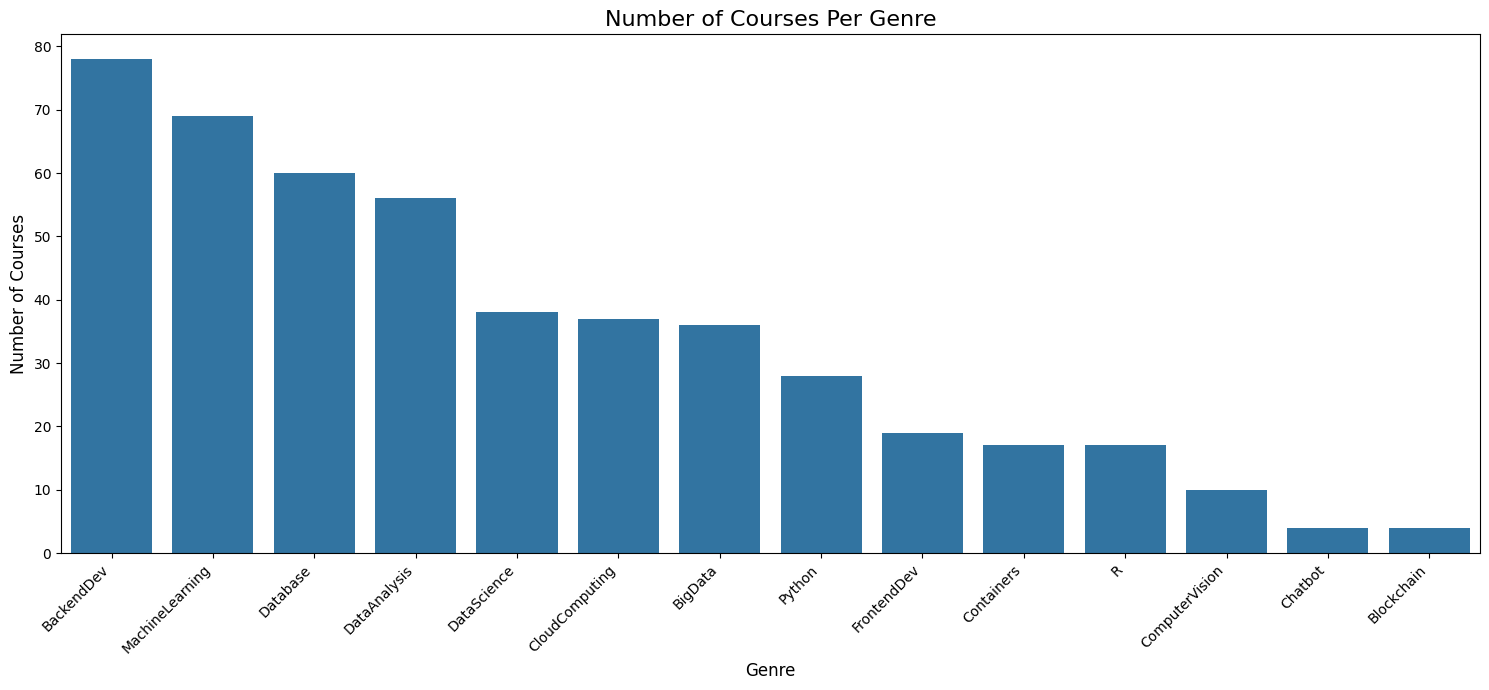

In [16]:
plt.figure(figsize=(15,7))
sns.barplot(x=genre_totals.index, y=genre_totals.values)
plt.title("Number of Courses Per Genre", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Courses", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Very few courses about Blockchain, Chatbot, ComputerVision, compared to Backend Development and Machine Learning.

###  EDA on the Course Enrollments


In [17]:
ratings_df.head()

user        item  rating
0  1889878    CC0101EN       5
1  1342067    CL0101EN       3
2  1990814  ML0120ENv3       5
3   380098    BD0211EN       5
4   779563    DS0101EN       3

3 Columns: user (unique ID), item (course ID), rating

In [18]:
ratings_df['rating'].unique()

array([5, 3, 4], dtype=int64)

Meaning of Each Rating:

<b>5</b>: Enrolled and Gave Maximum Rating

<b>4</b>: Enrolled and Gave Good Rating

<b>3</b>: Enrolled and Gave Low Rating (Below Expectations)

In [19]:
# check size of dataset
ratings_df.shape[0]

233306

233306 enrollments. However, most students will have enrolled in more than one class.


In [20]:
# group users
user_rating_counts = ratings_df.groupby('user').size()

# count total UNIQUE users
total_users = len(user_rating_counts)

print("Total Number of Unique Users:", total_users)


Total Number of Unique Users: 33901


In [21]:
# Assuming user_rating_counts contains the number of ratings per user from the previous task
user_enrollment_stats = user_rating_counts.describe()

print("User Enrollment Statistics:")
print(user_enrollment_stats)

User Enrollment Statistics:
count    33901.000000
mean         6.881980
std          5.823548
min          1.000000
25%          2.000000
50%          6.000000
75%          9.000000
max         61.000000
dtype: float64


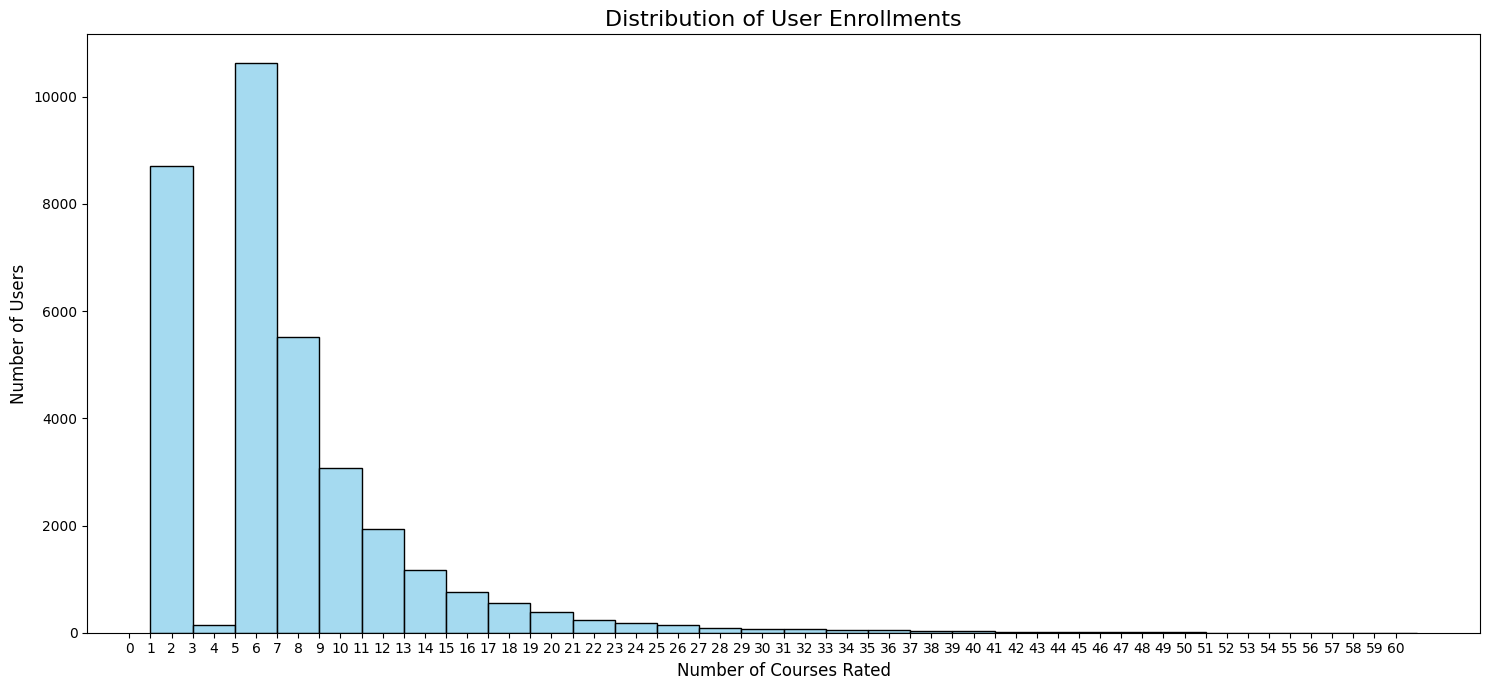

In [22]:
plt.figure(figsize=(15,7))
sns.histplot(user_rating_counts, 
             bins=30,  
             color='skyblue',
             edgecolor='black')

plt.title('Distribution of User Enrollments', fontsize=16)
plt.xlabel('Number of Courses Rated', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(np.arange(0,max(user_rating_counts)))
plt.tight_layout()
plt.show()

Get Top 20 Courses

In [23]:
# group items by count ratings
course_enrollments = ratings_df.groupby('item').size().sort_values(ascending=False)

# top 20 courses
top_20_courses = course_enrollments.head(20)

top_20_courses_df = pd.DataFrame({
    'Course_ID': top_20_courses.index, 
    'Enrolls': top_20_courses.values
})

# Merge dataframes
top_20_with_titles = pd.merge(
    top_20_courses_df, 
    course_df[['COURSE_ID', 'TITLE']], 
    left_on='Course_ID', 
    right_on='COURSE_ID'
)

# select and rename columns
top_20_with_titles = top_20_with_titles[['TITLE', 'Enrolls']]

# Sort and display
top_20_with_titles = top_20_with_titles.sort_values('Enrolls', ascending=False)
print(top_20_with_titles)

                                           TITLE  Enrolls
0                        python for data science    14936
1                   introduction to data science    14477
2                                   big data 101    13291
3                                     hadoop 101    10599
4                      data analysis with python     8303
5                       data science methodology     7719
6                   machine learning with python     7644
7                           spark fundamentals i     7551
8   data science hands on with open source tools     7199
9                          blockchain essentials     6719
10                data visualization with python     6709
11                             deep learning 101     6323
12                        build your own chatbot     5512
13                            r for data science     5237
14                                statistics 101     5015
15                         introduction to cloud     4983
16   docker es

Percentage of Top 20 Compared to Rest

In [24]:
total = ratings_df.shape[0]
top = 0

for enrolls in top_20_with_titles["Enrolls"]:
    top += enrolls

print(f"Percentage of the top course enrollments {round((top * 100)/total, 2)}%")

Percentage of the top course enrollments 63.3%


### Bag of Words (BoW)

Tokenize Strings

In [25]:
course_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_processed.csv"
course_content_df = pd.read_csv(course_url)

In [26]:
course_content_df.head()

COURSE_ID                                              TITLE  \
0    ML0201EN  robots are coming  build iot apps with watson ...   
1    ML0122EN                accelerating deep learning with gpu   
2  GPXX0ZG0EN  consuming restful services using the reactive ...   
3    RP0105EN         analyzing big data in r using apache spark   
4  GPXX0Z2PEN  containerizing  packaging  and running a sprin...   

                                         DESCRIPTION  
0  have fun with iot and learn along the way  if ...  
1  training complex deep learning models with lar...  
2  learn how to use a reactive jax rs client to a...  
3  apache spark is a popular cluster computing fr...  
4  learn how to containerize  package  and run a ...

In [27]:
# merge title and descriptions for BoW
course_content_df['course_texts'] = course_content_df[['TITLE', 'DESCRIPTION']].agg(' '.join, axis=1)
course_content_df = course_content_df.reset_index()
course_content_df['index'] = course_content_df.index

In [28]:
course_content_df.head()

index   COURSE_ID                                              TITLE  \
0      0    ML0201EN  robots are coming  build iot apps with watson ...   
1      1    ML0122EN                accelerating deep learning with gpu   
2      2  GPXX0ZG0EN  consuming restful services using the reactive ...   
3      3    RP0105EN         analyzing big data in r using apache spark   
4      4  GPXX0Z2PEN  containerizing  packaging  and running a sprin...   

                                         DESCRIPTION  \
0  have fun with iot and learn along the way  if ...   
1  training complex deep learning models with lar...   
2  learn how to use a reactive jax rs client to a...   
3  apache spark is a popular cluster computing fr...   
4  learn how to containerize  package  and run a ...   

                                        course_texts  
0  robots are coming  build iot apps with watson ...  
1  accelerating deep learning with gpu training c...  
2  consuming restful services using the reactive ...  
3  analyzing big data in r using apache spark apa...  
4  containerizing  packaging  and running a sprin...

Tokenize Function

In [29]:
import traceback


def tokenize_course(course, keep_only_nouns=True):
        # get string
        course = str(course)
        
        # stop words
        stop_words = set(stopwords)
        
        # tokenize
        word_tokens = word_tokenize(course)
        
        # remove stopwords and numbers
        word_tokens = [
            w for w in word_tokens 
            if (not w.lower() in stop_words) and (not w.isnumeric())
        ]
        
        # keep only nouns
        if keep_only_nouns:
            # filter tags
            filter_list = [
                'WDT', 'WP', 'WRB', 'FW', 'IN', 'JJR', 'JJS', 'MD', 
                'PDT', 'POS', 'PRP', 'RB', 'RBR', 'RBS', 'RP'
            ]
            
            # tag words
            tags = nltk.pos_tag(word_tokens)
            
            # filter
            word_tokens = [
                word for word, pos in tags 
                if pos not in filter_list
            ]
        
        return word_tokens

Tokenize Courses

In [30]:
tokenized_courses = []
for index, course_text in enumerate(course_content_df['course_texts']):
    # Attempt tokenization
    tokens = tokenize_course(course_text, True)
    tokenized_courses.append(tokens)
        

# add tokenized courses to df
course_content_df['tokenized_courses'] = tokenized_courses


In [31]:
course_content_df.head()

index   COURSE_ID                                              TITLE  \
0      0    ML0201EN  robots are coming  build iot apps with watson ...   
1      1    ML0122EN                accelerating deep learning with gpu   
2      2  GPXX0ZG0EN  consuming restful services using the reactive ...   
3      3    RP0105EN         analyzing big data in r using apache spark   
4      4  GPXX0Z2PEN  containerizing  packaging  and running a sprin...   

                                         DESCRIPTION  \
0  have fun with iot and learn along the way  if ...   
1  training complex deep learning models with lar...   
2  learn how to use a reactive jax rs client to a...   
3  apache spark is a popular cluster computing fr...   
4  learn how to containerize  package  and run a ...   

                                        course_texts  \
0  robots are coming  build iot apps with watson ...   
1  accelerating deep learning with gpu training c...   
2  consuming restful services using the reactive ...   
3  analyzing big data in r using apache spark apa...   
4  containerizing  packaging  and running a sprin...   

                                   tokenized_courses  
0  [robots, coming, build, iot, apps, watson, swi...  
1  [accelerating, deep, learning, gpu, training, ...  
2  [consuming, restful, services, reactive, jax, ...  
3  [analyzing, big, data, apache, spark, apache, ...  
4  [containerizing, packaging, running, spring, b...

Creat Dictionary of Tokenized Courses

In [32]:
dictionary = corpora.Dictionary(course_content_df['tokenized_courses'])

In [33]:
corpus = [dictionary.doc2bow(tokens) for tokens in course_content_df['tokenized_courses']]

Create Final Data Frame of BoW

In [34]:
bow_features = []

# go through df
for doc_index, (tokens, doc_bow) in enumerate(zip(course_content_df['tokenized_courses'], corpus)):
    # get course_id
    course_id = course_content_df.loc[doc_index, 'COURSE_ID']
    
    # get each value
    for token_id, bow_value in doc_bow:
        bow_features.append({
            'doc_index': doc_index,
            'doc_id': course_id,
            'token': dictionary[token_id],
            'bow': bow_value,
        })

# create df from list of dicts
bow_df = pd.DataFrame(bow_features)

# visualise df
bow_df.head()

doc_index    doc_id   token  bow
0          0  ML0201EN      ai    2
1          0  ML0201EN    apps    2
2          0  ML0201EN   build    2
3          0  ML0201EN   cloud    1
4          0  ML0201EN  coming    1

### Creating TF-IDF Data Frame

A weighted frequency representation, build upon the BoW representation. Reduces impact of very common words and gives more weight to informative and unique tokens.

In [35]:
def prepare_tfidf_features(course_content_df, corpus, dictionary):
    # Create TF-IDF model
    tfidf_model = TfidfModel(corpus)
    
    # Get TF-IDF corpus
    tfidf_corpus = tfidf_model[corpus]
    
    # Prepare TF-IDF features
    tfidf_features = []
    
    for doc_index, (tokens, doc_tfidf) in enumerate(zip(course_content_df['tokenized_courses'], tfidf_corpus)):
        course_id = course_content_df.loc[doc_index, 'COURSE_ID']
        
        # Create a full-length TF-IDF vector
        tfidf_vector = [0] * len(dictionary)
        for token_id, tfidf_value in doc_tfidf:
            tfidf_vector[token_id] = tfidf_value
        
        tfidf_features.append({
            'doc_id': course_id,
            'tfidf_vector': tfidf_vector
        })
    
    return pd.DataFrame(tfidf_features)


tfidf_df = prepare_tfidf_features(course_content_df, corpus, dictionary)

tfidf_df.head()

doc_id                                       tfidf_vector
0    ML0201EN  [0.14924914196903763, 0.21037779807849488, 0.1...
1    ML0122EN  [0.08427076132702185, 0, 0, 0.0603265655251077...
2  GPXX0ZG0EN  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0450530...
3    RP0105EN  [0, 0, 0, 0, 0, 0, 0.15394369183994056, 0, 0, ...
4  GPXX0Z2PEN  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0384286...

### Creating Text Embedding Dateframe

Uses a semantic vector representation, converts text to dense vector representations from learned models. Represents meaning in continuous vector space.

In [36]:
# create model
w2v_model = Word2Vec(
    sentences=course_content_df['tokenized_courses'], 
    vector_size=100,  
    window=5,       
    min_count=2,    
    workers=4    
)

# get document embedding
def get_document_embedding(tokens, model, vector_size=100):
    # get average word vectors
    doc_vectors = [model.wv[token] for token in tokens if token in model.wv]
    
    if not doc_vectors:
        return np.zeros(vector_size)
    
    return np.mean(doc_vectors, axis=0)

# create doc embeddings
doc_embeddings = np.array([
    get_document_embedding(tokens, w2v_model) 
    for tokens in course_content_df['tokenized_courses']
])

# create df
embedding_df = pd.DataFrame(
    doc_embeddings, 
    columns=[f'embed_{i}' for i in range(doc_embeddings.shape[1])]
)
embedding_df['doc_id'] = course_content_df['COURSE_ID']
embedding_df['course_title'] = course_content_df['TITLE']

embedding_df.head()

embed_0   embed_1   embed_2   embed_3   embed_4   embed_5   embed_6  \
0 -0.043401  0.099147 -0.003865  0.002492  0.007311 -0.134357  0.064512   
1 -0.046729  0.107972 -0.005856  0.001869  0.009769 -0.146928  0.068971   
2 -0.051570  0.119559 -0.006973  0.005359  0.012068 -0.163463  0.073728   
3 -0.068581  0.153951 -0.005381  0.009302  0.012098 -0.212441  0.102424   
4 -0.036953  0.076034 -0.001829  0.003951  0.009585 -0.103980  0.049302   

    embed_7   embed_8   embed_9  ...  embed_92  embed_93  embed_94  embed_95  \
0  0.159579 -0.064915 -0.029554  ...  0.013952  0.012442  0.106561  0.086083   
1  0.177166 -0.073608 -0.032323  ...  0.018150  0.012906  0.118017  0.094775   
2  0.188655 -0.080609 -0.034954  ...  0.015064  0.012371  0.126422  0.099046   
3  0.253785 -0.103066 -0.046741  ...  0.025723  0.021410  0.170118  0.136100   
4  0.119615 -0.050279 -0.025012  ...  0.013933  0.010347  0.084057  0.063315   

   embed_96  embed_97  embed_98  embed_99      doc_id  \
0  0.068702 -0.106038  0.027910 -0.013781    ML0201EN   
1  0.076431 -0.118158  0.031771 -0.017914    ML0122EN   
2  0.080113 -0.126840  0.034158 -0.016107  GPXX0ZG0EN   
3  0.104946 -0.166863  0.044544 -0.022397    RP0105EN   
4  0.051315 -0.079652  0.020692 -0.014819  GPXX0Z2PEN   

                                        course_title  
0  robots are coming  build iot apps with watson ...  
1                accelerating deep learning with gpu  
2  consuming restful services using the reactive ...  
3         analyzing big data in r using apache spark  
4  containerizing  packaging  and running a sprin...  

[5 rows x 102 columns]

### Finding Similar Courses Example

Target Course: "machine learning with python"

In [37]:
bow_df

doc_index      doc_id       token  bow
0              0    ML0201EN          ai    2
1              0    ML0201EN        apps    2
2              0    ML0201EN       build    2
3              0    ML0201EN       cloud    1
4              0    ML0201EN      coming    1
...          ...         ...         ...  ...
10132        306  excourse93   modifying    1
10133        306  excourse93  objectives    1
10134        306  excourse93      pieces    1
10135        306  excourse93     plugins    1
10136        306  excourse93    populate    1

[10137 rows x 4 columns]

In [38]:
class CourseSimilarityFinder:
    def __init__(self, course_content_df, bow_features, tfidf_df, embedding_df, dictionary):
        self.course_df = course_content_df
        self.bow_features = bow_features
        self.tfidf_df = tfidf_df
        self.embedding_df = embedding_df
        self.dictionary = dictionary
        
        # Preprocess BoW features
        self.bow_course_features = self._prepare_bow_features()
    
    def _prepare_bow_features(self):
        # Dynamically extract feature columns from course_content_df
        content_features = [
            col for col in self.course_df.columns 
            if col not in ['COURSE_ID', 'TITLE', 'DESCRIPTION', 'course_texts', 'tokenized_courses']
        ]
        
        # Prepare feature vectors
        course_feature_vectors = {}
        
        # Get unique tokens
        unique_tokens = bow_df['token'].unique()
        
        for course_id in self.course_df['COURSE_ID']:
            # Initialize feature vector
            feature_vector = np.zeros(len(unique_tokens))
            
            # Add content features
            course_content_features = self.course_df[
                self.course_df['COURSE_ID'] == course_id
            ][content_features].values[0]
            
            # Get BoW features for this course
            course_bow = bow_df[bow_df['doc_id'] == course_id]
            
            # Populate BoW vector
            for _, row in course_bow.iterrows():
                token = row['token']
                bow_value = row['bow']
                
                # Find token index
                token_index = np.where(unique_tokens == token)[0]
                if len(token_index) > 0:
                    feature_vector[token_index[0]] = bow_value
            
            # Combine with content features
            full_feature_vector = np.concatenate([course_content_features, feature_vector])
            
            course_feature_vectors[course_id] = full_feature_vector
        
        return course_feature_vectors

    def find_similar_courses(self, target_course_id, similarity_method='embedding', threshold=0.3):
        if similarity_method == 'bow':
            # Prepare feature matrix and course IDs
            feature_matrix = np.array(list(self.bow_course_features.values()))
            course_ids = list(self.bow_course_features.keys())
            
            # Find target course index
            target_index = course_ids.index(target_course_id)
            
            # Get target vector
            target_vector = feature_matrix[target_index].reshape(1, -1)
            
            # Remove target course from matrix and course_ids
            feature_matrix_filtered = np.delete(feature_matrix, target_index, axis=0)
            course_ids_filtered = np.delete(course_ids, target_index)
            
            # Get cosine similarity
            similarities = cosine_similarity(target_vector, feature_matrix_filtered)[0]
            
            # Create similarity series
            similarity_series = pd.Series(similarities, index=course_ids_filtered)
            
            # Select courses above threshold
            similar_courses_mask = (similarity_series >= threshold) & (similarity_series < 1)
            similar_courses = self.course_df[
                self.course_df['COURSE_ID'].isin(similarity_series[similar_courses_mask].index)
            ].copy()
            
            # Add scores
            similar_courses['Similarity'] = similar_courses['COURSE_ID'].map(similarity_series)
            
            # Sort
            similar_courses = similar_courses.sort_values('Similarity', ascending=False)
            
            return similar_courses
                    
        elif similarity_method == 'tfidf':
            # Find tfidf vector
            target_tfidf = self.tfidf_df[self.tfidf_df['doc_id'] == target_course_id]['tfidf_vector'].values[0]
            
            # Create np array
            target_tfidf = np.array(target_tfidf)
            
            # Create matrix
            tfidf_matrix = np.array(self.tfidf_df['tfidf_vector'].tolist())
            
            # Normalize TF-IDF vectors
            norms = np.linalg.norm(tfidf_matrix, axis=1)
            norms[norms == 0] = 1
            tfidf_matrix = tfidf_matrix / norms[:, np.newaxis]
            
            # Get cosine similarities
            similarities = cosine_similarity(
                target_tfidf.reshape(1, -1), 
                tfidf_matrix
            )[0]
            
            # Create similarity series
            similarity_series = pd.Series(
                similarities, 
                index=self.tfidf_df['doc_id']
            )
        
        else:  # embedding
            # Get embedding features
            embedding_matrix = self.embedding_df.drop(['doc_id', 'course_title'], axis=1).values
            
            # Get target course
            target_embedding = self.embedding_df[
                self.embedding_df['doc_id'] == target_course_id
            ].drop(['doc_id', 'course_title'], axis=1).values
            
            # Normalize embedding vectors
            norms = np.linalg.norm(embedding_matrix, axis=1)
            norms[norms == 0] = 1
            embedding_matrix = embedding_matrix / norms[:, np.newaxis]
            
            # Get cosine similarities
            similarities = cosine_similarity(target_embedding, embedding_matrix)[0]
            
            # Create similarity series
            similarity_series = pd.Series(
                similarities, 
                index=self.embedding_df['doc_id']
            )
        
        # Select courses above threshold
        similar_courses_mask = (similarity_series >= threshold) & (similarity_series < 1)
        similar_courses = self.course_df[
            self.course_df['COURSE_ID'].isin(similarity_series[similar_courses_mask].index)
        ].copy()
        
        # Add scores
        similar_courses['Similarity'] = similar_courses['COURSE_ID'].map(similarity_series)
        
        # Sort
        similar_courses = similar_courses.sort_values('Similarity', ascending=False)
        
        return similar_courses
            
    def display_similar_courses(self, target_course_id, similarity_method='embedding', threshold=0.3, top_n=5):
        # find similar
        similar_courses = self.find_similar_courses(target_course_id, similarity_method, threshold)
        
        # get target
        target_course = self.course_df[self.course_df['COURSE_ID'] == target_course_id]
        
        # print results
        print(f"Target Course: {target_course['TITLE'].values[0]} (ID: {target_course_id})")
        print(f"Courses Similar using {similarity_method.upper()} Similarity:")
        print("-" * 50)
        
        if len(similar_courses) == 0:
            print("No similar courses found.")
            return similar_courses
        
        # display courses
        for _, course in similar_courses.head(top_n).iterrows():
            print(f"Course ID: {course['COURSE_ID']}")
            print(f"Title: {course['TITLE']}")
            print(f"Similarity: {course['Similarity']:.4f}")
            print("-" * 50)
        
        return similar_courses

In [39]:
# create finder with dataframes
similarity_finder = CourseSimilarityFinder(
    course_content_df, 
    bow_features,  # from previous BoW preparation
    tfidf_df,     # from TF-IDF preparation
    embedding_df, # from Word2Vec embedding
    dictionary    # Gensim dictionary
)

# Target course
target_course_id = 'ML0101ENv3'

# Find and display similar courses using different methods
print("\n1. BoW Similarity:")
bow_similar = similarity_finder.display_similar_courses(target_course_id, 'bow', threshold=0.01)

print("\n2. TF-IDF Similarity:")
tfidf_similar = similarity_finder.display_similar_courses(target_course_id, 'tfidf', threshold=0.01)

print("\n3. Embedding Similarity:")
embedding_similar = similarity_finder.display_similar_courses(target_course_id, 'embedding', threshold=0.5)


1. BoW Similarity:
Target Course: machine learning with python (ID: ML0101ENv3)
Courses Similar using BOW Similarity:
--------------------------------------------------
Course ID: ML0151EN
Title: machine learning with r
Similarity: 0.9995
--------------------------------------------------
Course ID: ML0109EN
Title: machine learning   dimensionality reduction
Similarity: 0.9994
--------------------------------------------------
Course ID: ML0115EN
Title: deep learning 101
Similarity: 0.9993
--------------------------------------------------
Course ID: excourse48
Title: introduction to machine learning  language processing
Similarity: 0.9991
--------------------------------------------------
Course ID: SC0105EN
Title: data science with scala
Similarity: 0.9990
--------------------------------------------------

2. TF-IDF Similarity:
Target Course: machine learning with python (ID: ML0101ENv3)
Courses Similar using TFIDF Similarity:
--------------------------------------------------
Cour

We can see other machine learning courses have closer similarities when using the cosine differences. These courses would probably be recommended for people who took the target course (machine learning with python).

# Content-Based Course Recommender System

### Content-Based Course Recommender System Using User Profiles and Course Genres

#### Creating User Profiles

Example: Courses with 3 Genres: Python, Database, MachineLearning

In [40]:
course_genres = ['Python', 'Database', 'MachineLearning']
courses = [['Machine Learning with Python', 1, 0, 1], ["SQL with Python", 1, 1, 0]]
courses_df = pd.DataFrame(courses, columns = ['Title'] + course_genres)
courses_df

Title  Python  Database  MachineLearning
0  Machine Learning with Python       1         0                1
1               SQL with Python       1         1                0

1st Course has Python and ML, 2nd Course has Python and DB

Example: Dataframe for User Ratings of Courses

In [41]:
users = [['user0', 'Machine Learning with Python', 3], ['user1', 'SQL with Python', 2]]
users_df = pd.DataFrame(users, columns = ['User', 'Title', 'Rating'])
users_df

User                         Title  Rating
0  user0  Machine Learning with Python       3
1  user1               SQL with Python       2

Using Matrices

In [42]:
# user 0 rated course 0 as 3 and course 1 as 0/NA (unknown or not interested)
u0 = np.array([[3, 0]])
u0

array([[3, 0]])

In [43]:
# the course genre's matrix
C = courses_df[['Python', 'Database', 'MachineLearning']].to_numpy()
C

array([[1, 0, 1],
       [1, 1, 0]], dtype=int64)

In [44]:
u0_weights = np.matmul(u0, C)
u0_weights

array([[3, 0, 3]], dtype=int64)

The weights of each course according to the ratings of the user is [3, 0, 3] after the matrix multiplication.

#### Generating Course Recommendations Based on User Profile and Course Genre Vectors

In [45]:
course_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_genre.csv"
course_genres_df = pd.read_csv(course_genre_url)

In [46]:
course_genres_df.head()

COURSE_ID                                              TITLE  Database  \
0    ML0201EN  robots are coming  build iot apps with watson ...         0   
1    ML0122EN                accelerating deep learning with gpu         0   
2  GPXX0ZG0EN  consuming restful services using the reactive ...         0   
3    RP0105EN         analyzing big data in r using apache spark         1   
4  GPXX0Z2PEN  containerizing  packaging  and running a sprin...         0   

   Python  CloudComputing  DataAnalysis  Containers  MachineLearning  \
0       0               0             0           0                0   
1       1               0             0           0                1   
2       0               0             0           0                0   
3       0               0             1           0                0   
4       0               0             0           1                0   

   ComputerVision  DataScience  BigData  Chatbot  R  BackendDev  FrontendDev  \
0               0            0        0        0  0           1            1   
1               0            1        0        0  0           0            0   
2               0            0        0        0  0           1            1   
3               0            0        1        0  1           0            0   
4               0            0        0        0  0           1            0   

   Blockchain  
0           0  
1           0  
2           0  
3           0  
4           0

In [47]:
profile_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_profile.csv"
profile_df = pd.read_csv(profile_genre_url)

In [48]:
profile_df.head()

user  Database  Python  CloudComputing  DataAnalysis  Containers  \
0     2      52.0    14.0             6.0          43.0         3.0   
1     4      40.0     2.0             4.0          28.0         0.0   
2     5      24.0     8.0            18.0          24.0         0.0   
3     7       2.0     0.0             0.0           2.0         0.0   
4     8       6.0     0.0             0.0           4.0         0.0   

   MachineLearning  ComputerVision  DataScience  BigData  Chatbot     R  \
0             33.0             0.0         29.0     41.0      2.0  18.0   
1             14.0             0.0         20.0     24.0      0.0   6.0   
2             30.0             0.0         22.0     14.0      2.0  14.0   
3              0.0             0.0          0.0      2.0      0.0   0.0   
4              0.0             0.0          0.0      6.0      0.0   2.0   

   BackendDev  FrontendDev  Blockchain  
0        34.0          9.0         6.0  
1         6.0          0.0         2.0  
2        26.0          4.0         6.0  
3         0.0          0.0         0.0  
4         0.0          0.0         0.0

The profile dataframe contains the course interests for each user.


In [49]:
profile_df[profile_df['user'] == 8]

user  Database  Python  CloudComputing  DataAnalysis  Containers  \
4     8       6.0     0.0             0.0           4.0         0.0   

   MachineLearning  ComputerVision  DataScience  BigData  Chatbot    R  \
4              0.0             0.0          0.0      6.0      0.0  2.0   

   BackendDev  FrontendDev  Blockchain  
4         0.0          0.0         0.0

Load Test Df

In [50]:
test_users_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"
test_users_df = pd.read_csv(test_users_url)

In [51]:
test_users_df.head()

user        item  rating
0  1889878    CC0101EN       5
1  1342067    CL0101EN       3
2  1990814  ML0120ENv3       5
3   380098    BD0211EN       5
4   779563    DS0101EN       3

In [52]:
# group the test users DataFrame by the 'user' column and find the maximum value for each group,
# then reset the index and drop the old index to obtain a DataFrame with unique user IDs
test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)

# extract the 'user' column from the test_users DataFrame and convert it to a list of user IDs
test_user_ids = test_users['user'].to_list()

# print the total number of test users by obtaining the length of the test_user_ids list
print(f"Total numbers of test users {len(test_user_ids)}")


Total numbers of test users 33901


Calculating Test Users

In [53]:
# dictionary for recommendations
res_dict = {}

# arbitrary threshold for recommendation
score_threshold = 20.0

# get all courses as a set
all_courses = set(course_genres_df['COURSE_ID'])

Generate Recommendation Scores Function

In [54]:
def generate_recommendation_scores():
    """
    Generate recommendation scores for users and courses.

    Returns:
    users (list): List of user IDs.
    courses (list): List of recommended course IDs.
    scores (list): List of recommendation scores.
    """

    # init empty lists
    users = []      
    courses = []    
    scores = []     

    # iterate over each user ID in the test_user_ids list
    for user_id in test_user_ids:
        # get the user profile data for the current user
        test_user_profile = profile_df[profile_df['user'] == user_id]

        # get the user vector for the current user id (replace with your method to obtain the user vector)
        test_user_vector = test_user_profile.iloc[0, 1:].values

        # get the known course ids for the current user
        enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].to_list()

        # calculate the unknown course ids
        unknown_courses = all_courses.difference(enrolled_courses)

        # filter the course_genres_df to include only unknown courses
        unknown_course_df = course_genres_df[course_genres_df['COURSE_ID'].isin(unknown_courses)]
        unknown_course_ids = unknown_course_df['COURSE_ID'].values

        # calculate the recommendation scores using dot product
        recommendation_scores = np.dot(unknown_course_df.iloc[:, 2:].values, test_user_vector)

        # append the results into the users, courses, and scores list
        for i in range(0, len(unknown_course_ids)):
            score = recommendation_scores[i]

            # only keep the courses with high recommendation score
            if score >= score_threshold:
                users.append(user_id)
                courses.append(unknown_course_ids[i])
                scores.append(recommendation_scores[i])

    return users, courses, scores

In [55]:
# generate recs
users, courses, scores = generate_recommendation_scores()

# store recommendations and users to dict
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = scores

# create pd df from dict
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])

# save as csv
res_df.to_csv("profile_rs_results.csv", index=False)

# show df
res_df


USER   COURSE_ID  SCORE
0             2    ML0201EN   43.0
1             2  GPXX0ZG0EN   43.0
2             2  GPXX0Z2PEN   37.0
3             2    DX0106EN   47.0
4             2  GPXX06RFEN   52.0
...         ...         ...    ...
479126  2102680  GPXX04P5EN   23.0
479127  2102680    ML0101EN   29.0
479128  2102680  excourse21   29.0
479129  2102680  excourse22   29.0
479130  2102680  excourse49   20.0

[479131 rows x 3 columns]

Now the users can have their recommendations sent to them according to their score. However, there are many problems with content based recommendation systems like this as they will only know what the user says, and maybe, the user wants to try something new but they will never be recommended something different.

Extra Analysis

Average recommendations per user: 28.94
Min recommendations for a user: 1
Max recommendations for a user: 236
Users with at least one recommendation: 16554 out of 33901 (48.8%)

Top 10 Most Frequently Recommended Courses:
1. foundations for big data analysis with sql
   Course ID: excourse72, Recommended 9138 times
2. analyzing big data with sql
   Course ID: excourse73, Recommended 9138 times
3. getting started with the data  apache spark makers build
   Course ID: TMP0105EN, Recommended 8954 times
4. analyzing big data in r using apache spark
   Course ID: RP0105EN, Recommended 8769 times
5. spark overview for scala analytics
   Course ID: SC0103EN, Recommended 7970 times
6. cloud computing applications  part 2  big data and applications in the cloud
   Course ID: excourse31, Recommended 7853 times
7. applied machine learning in python
   Course ID: excourse21, Recommended 7671 times
8. introduction to data science in python
   Course ID: excourse22, Recommended 7671 times
9. acceler

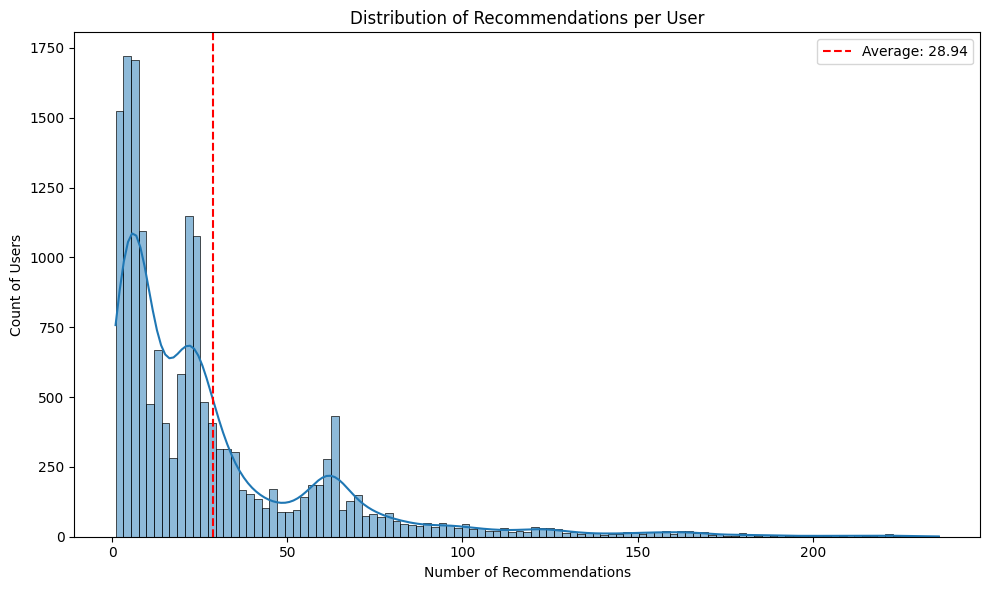

In [56]:
def analyze_recommendations_per_user(res_df):
    # count recommendations per user
    recs_per_user = res_df.groupby('USER').size()
    
    # average
    avg_recs = recs_per_user.mean()
    
    # min max
    min_recs = recs_per_user.min()
    max_recs = recs_per_user.max()
    
    # unique users
    users_with_recs = recs_per_user.shape[0]
    total_users = len(test_user_ids)
    
    print(f"Average recommendations per user: {avg_recs:.2f}")
    print(f"Min recommendations for a user: {min_recs}")
    print(f"Max recommendations for a user: {max_recs}")
    print(f"Users with at least one recommendation: {users_with_recs} out of {total_users} ({users_with_recs/total_users*100:.1f}%)")
    
    return avg_recs, recs_per_user

# find the most frequently recommended courses
def get_top_recommended_courses(res_df, top_n=10):
    # create mapping of course ids to titles
    course_titles = dict(zip(course_genres_df['COURSE_ID'], course_genres_df['TITLE']))
    
    # count frequency of each course in recommendations
    course_counts = res_df['COURSE_ID'].value_counts().reset_index()
    course_counts.columns = ['COURSE_ID', 'Recommendation_Count']
    
    # get top N courses
    top_courses = course_counts.head(top_n).copy()
    
    # add course titles
    top_courses.loc[:, 'Course_Title'] = top_courses['COURSE_ID'].map(course_titles)
    
    print(f"\nTop {top_n} Most Frequently Recommended Courses:")
    for i, (_, row) in enumerate(top_courses.iterrows(), 1):
        course_id = row['COURSE_ID']
        count = row['Recommendation_Count']
        title = row['Course_Title']
        
        print(f"{i}. {title}")
        print(f"   Course ID: {course_id}, Recommended {count} times")
    
    return top_courses

# run analysis
avg_recs, recs_distribution = analyze_recommendations_per_user(res_df)
top_courses = get_top_recommended_courses(res_df)


plt.figure(figsize=(10, 6))
sns.histplot(recs_distribution, kde=True)
plt.title('Distribution of Recommendations per User')
plt.xlabel('Number of Recommendations')
plt.ylabel('Count of Users')
plt.axvline(avg_recs, color='red', linestyle='--', label=f'Average: {avg_recs:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

### Content-Based Course Recommender System using Course Similarities

We can download a pandas dataframe of the similarity matrices already calculated:

In [57]:
sim_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/sim.csv"

In [58]:
sim_df = pd.read_csv(sim_url)
sim_df

0         1         2         3         4         5         6  \
0    1.000000  0.088889  0.088475  0.065556  0.048810  0.104685  0.065202   
1    0.088889  1.000000  0.055202  0.057264  0.012182  0.078379  0.032545   
2    0.088475  0.055202  1.000000  0.026463  0.039406  0.000000  0.000000   
3    0.065556  0.057264  0.026463  1.000000  0.000000  0.250490  0.390038   
4    0.048810  0.012182  0.039406  0.000000  1.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
302  0.033944  0.028239  0.018270  0.094759  0.060474  0.064851  0.053856   
303  0.076825  0.063911  0.082698  0.030638  0.030415  0.000000  0.000000   
304  0.072898  0.138270  0.133400  0.017443  0.129871  0.009285  0.000000   
305  0.039276  0.031367  0.012684  0.018796  0.000000  0.015008  0.024926   
306  0.121113  0.076940  0.000000  0.158073  0.000000  0.126211  0.157219   

            7         8         9  ...       297       298       299  \
0    0.143346  0.000000  0.024405  ...  0.012695  0.070225  0.058224   
1    0.119251  0.044162  0.000000  ...  0.180593  0.124631  0.087187   
2    0.154303  0.000000  0.000000  ...  0.040996  0.037796  0.013430   
3    0.000000  0.000000  0.000000  ...  0.151882  0.420084  0.427908   
4    0.085126  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
..        ...       ...       ...  ...       ...       ...       ...   
302  0.039467  0.036539  0.060474  ...  0.047186  0.116008  0.137406   
303  0.119098  0.055132  0.045622  ...  0.177989  0.092381  0.145126   
304  0.254274  0.094165  0.025974  ...  0.153128  0.105191  0.138692   
305  0.082199  0.076102  0.055978  ...  0.149234  0.093962  0.162170   
306  0.000000  0.106668  0.039231  ...  0.142850  0.250859  0.260731   

          300       301       302       303       304       305       306  
0    0.046610  0.025850  0.033944  0.076825  0.072898  0.039276  0.121113  
1    0.093060  0.019354  0.028239  0.063911  0.138270  0.031367  0.076940  
2    0.037630  0.000000  0.018270  0.082698  0.133400  0.012684  0.000000  
3    0.055764  0.000000  0.094759  0.030638  0.017443  0.018796  0.158073  
4    0.096877  0.000000  0.060474  0.030415  0.129871  0.000000  0.000000  
..        ...       ...       ...       ...       ...       ...       ...  
302  0.211743  0.256220  1.000000  0.211520  0.168595  0.129766  0.263734  
303  0.527636  0.249675  0.211520  1.000000  0.242269  0.416067  0.178384  
304  0.281108  0.132977  0.168595  0.242269  1.000000  0.220159  0.128902  
305  0.476644  0.222350  0.129766  0.416067  0.220159  1.000000  0.126274  
306  0.099901  0.249325  0.263734  0.178384  0.128902  0.126274  1.000000  

[307 rows x 307 columns]

Alternatively, we can use the BoW, TF-IDF, and Embedding Similarity dataframes that we made during EDA and Feature Engineering.

In [59]:
# create pivot table
bow_pivot = bow_df.pivot(index='doc_id', columns='token', values='bow').fillna(0)

# calculate BoW similarity matrix
bow_similarity_matrix = cosine_similarity(bow_pivot)

# extract TF-IDF vectors
tfidf_matrix = np.array(tfidf_df['tfidf_vector'].tolist())

# calculate TF-IDF similarity matrix
tfidf_similarity_matrix = cosine_similarity(tfidf_matrix)

# get embedding matrix from embedding df
embedding_matrix = embedding_df.drop(['doc_id', 'course_title'], axis=1).values

# calculate similarity matrix for embedding
embedding_similarity_matrix = cosine_similarity(embedding_matrix)

# BoW Similarity Matrix
bow_similarity_df = pd.DataFrame(bow_similarity_matrix)

# TF-IDF Similarity Matrix
tfidf_similarity_df = pd.DataFrame(tfidf_similarity_matrix)

# Embedding Similarity Matrix
embedding_similarity_df = pd.DataFrame(embedding_similarity_matrix)

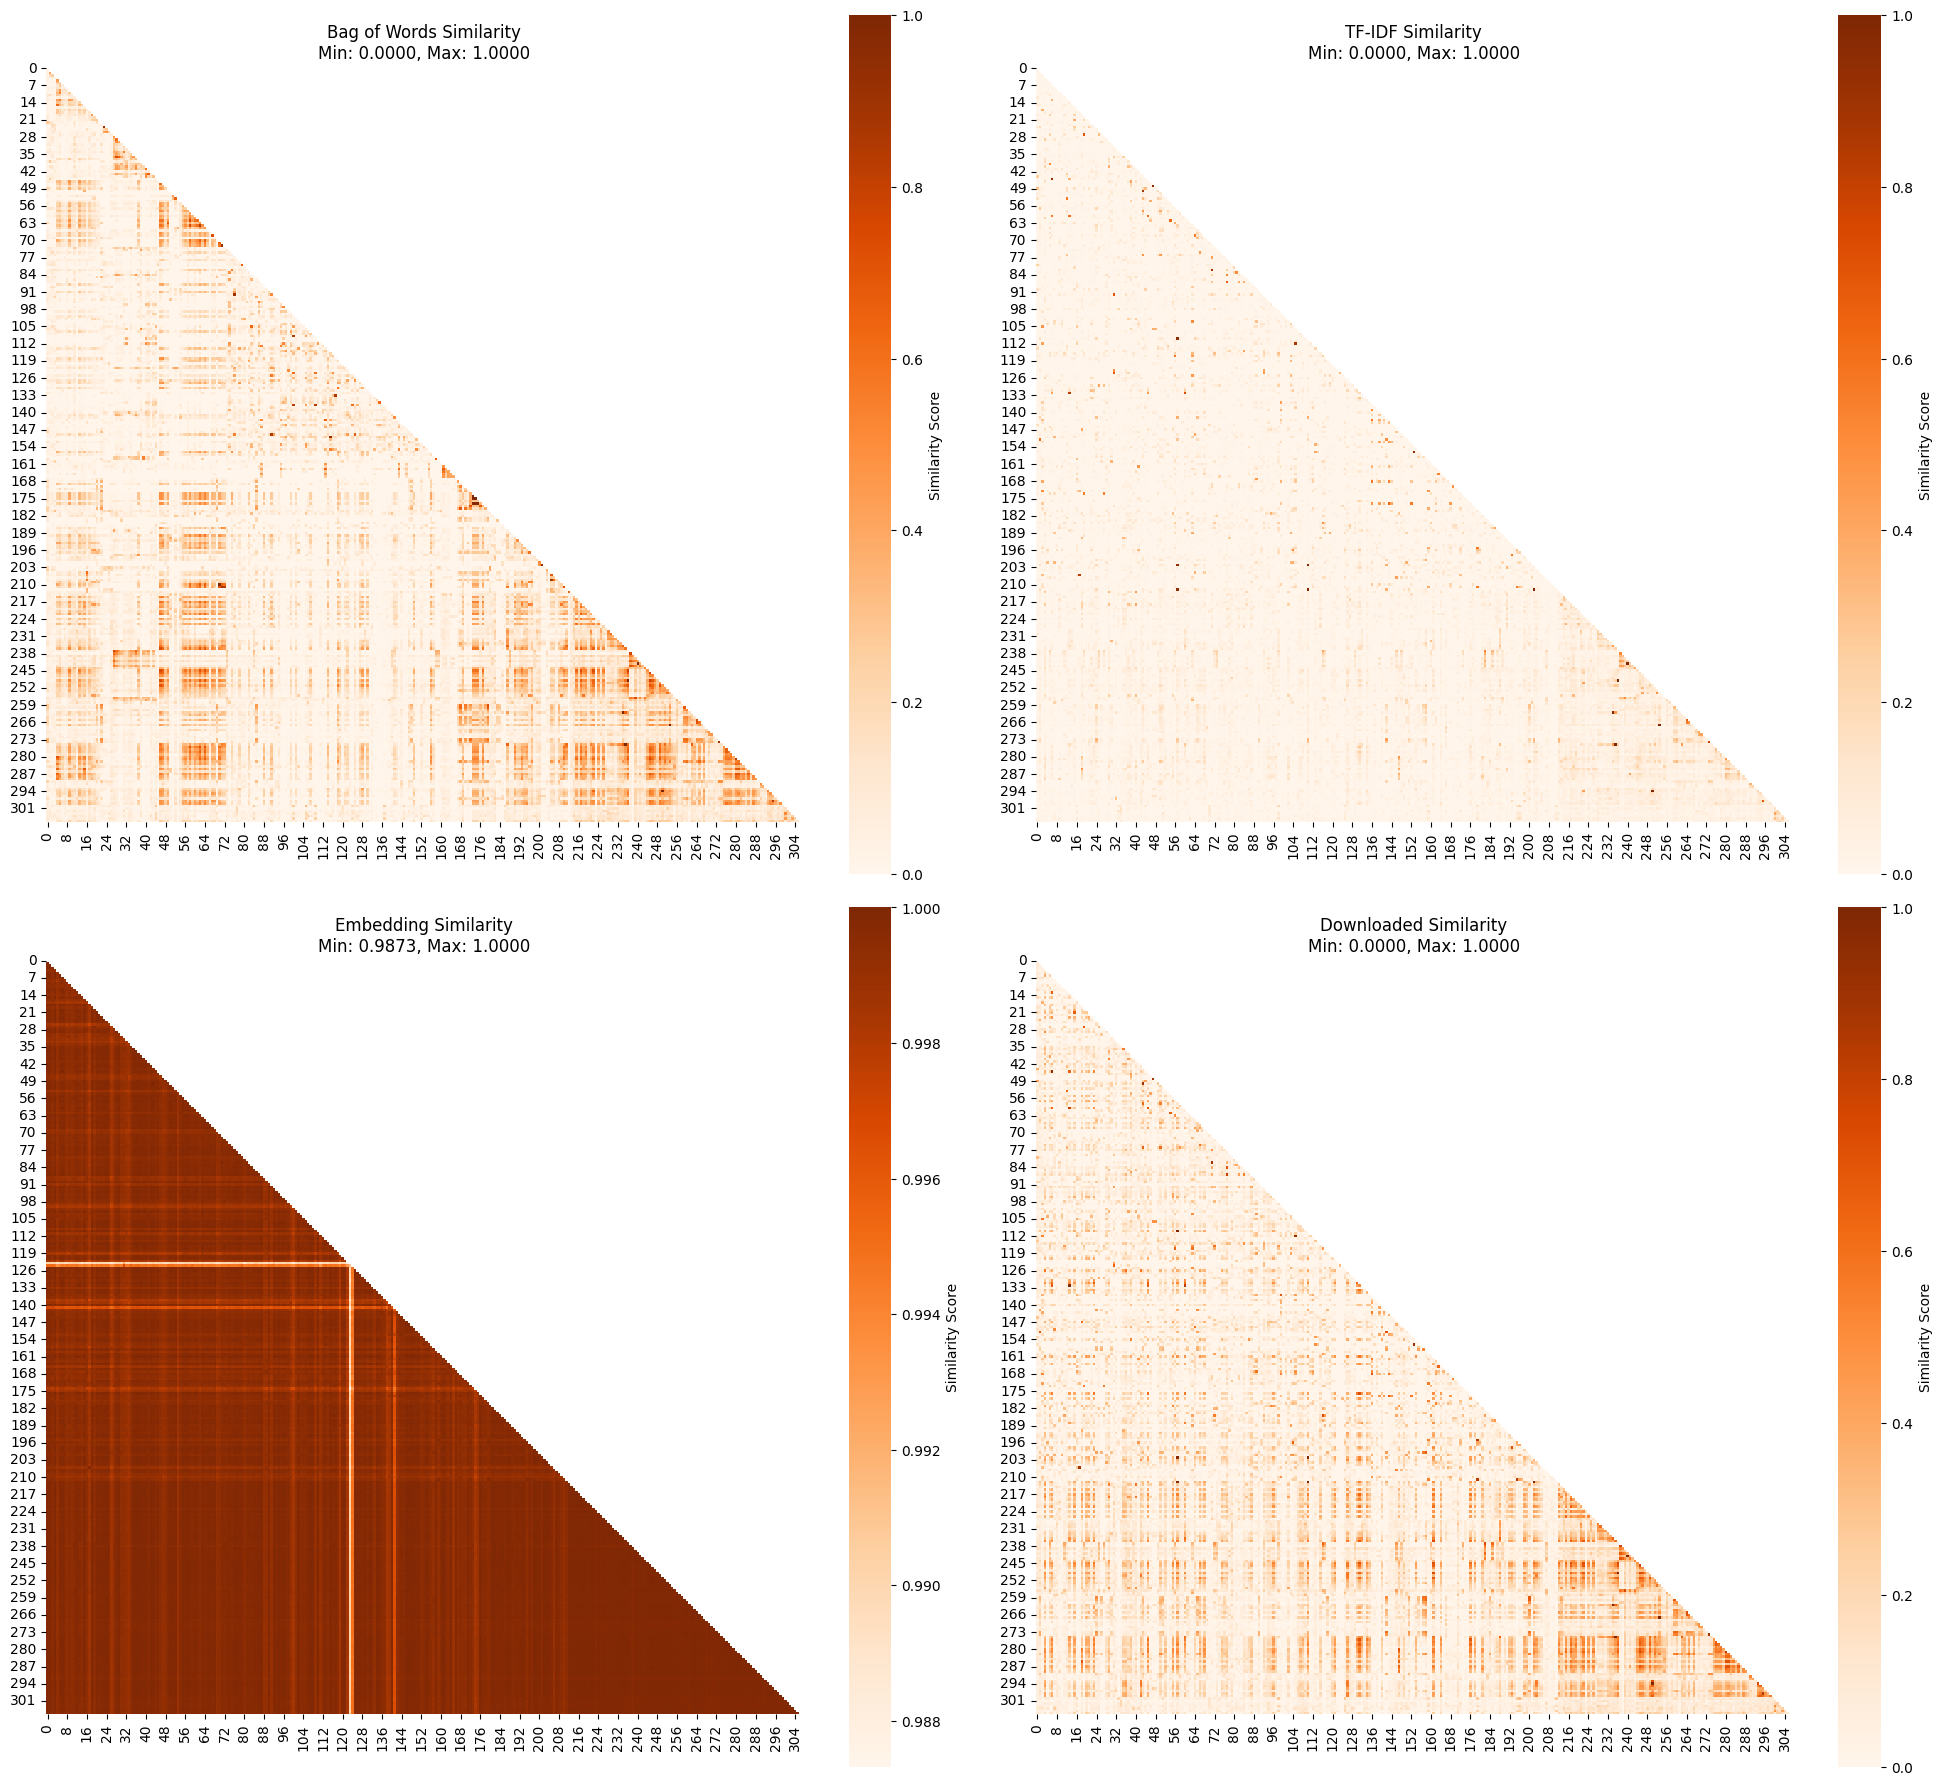

In [60]:
# list of similarity matrices and their names
similarity_matrices = [
    (bow_similarity_df, 'Bag of Words Similarity'),
    (tfidf_similarity_df, 'TF-IDF Similarity'),
    (embedding_similarity_df, 'Embedding Similarity'),
    (sim_df, 'Downloaded Similarity')
]

# create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.flatten()

# iterate through matrices and plot
for idx, (sim_matrix, title) in enumerate(similarity_matrices):
    # create a mask for the upper triangle
    mask = np.triu(np.ones_like(sim_matrix, dtype=bool))
    
    # determine dynamic color scaling
    if title == 'Embedding Similarity':
        vmin = sim_matrix.values[~np.eye(sim_matrix.shape[0], dtype=bool)].min()
        vmax = 1.0
    else:
        vmin = sim_matrix.values[~np.eye(sim_matrix.shape[0], dtype=bool)].min()
        vmax = sim_matrix.values[~np.eye(sim_matrix.shape[0], dtype=bool)].max()
        
    # plot heatmap
    sns.heatmap(sim_matrix, 
                mask=mask, 
                cmap=plt.cm.Oranges,
                vmin=vmin, 
                vmax=vmax, 
                center=(vmin + vmax) / 2,
                square=True, 
                ax=axes[idx],
                cbar_kws={'label': 'Similarity Score'}
    )
    
    # set title
    axes[idx].set_title(f'{title}\nMin: {vmin:.4f}, Max: {vmax:.4f}')

plt.tight_layout()
plt.show()

The heatmaps shows that there are some courses who are similar when looking at their cosine differences. We can guess that the downloaded similarities use a Bag of Words approach as it is similar to ours. The TF-IDF similarities are much harsher than the BoW, and the embedding is much less harsh.

#### Creating A Recommendation For a User

In [61]:
def generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, sim_matrix, course_id_mapping, matrix_type='default', max_recommendations=20):
    # create a dict for recs
    res = {}
    
    # threshold for each features
    if matrix_type == 'Embedding Similarity':
        threshold = 0.999  # Very high threshold for embedding similarities
    elif matrix_type == 'Bag of Words Similarity':
        threshold = 0.5   # Lower threshold for Bag of Words
    elif matrix_type == 'TF-IDF Similarity':
        threshold = 0.3   # Moderate threshold for TF-IDF
    else:
        threshold = 0.5   # Default threshold
    
    # get enrolled and unselected courses
    valid_enrolled_courses = [course for course in enrolled_course_ids if course in course_id_mapping]
    valid_unselected_courses = [course for course in unselected_course_ids if course in course_id_mapping]
    
    # limit embedded recommendations
    if matrix_type == 'Embedding Similarity':
        # collect similarities
        all_similarities = []
        
        for enrolled_course in valid_enrolled_courses:
            enrolled_idx = course_id_mapping[enrolled_course]
            
            for unselect_course in valid_unselected_courses:
                unselect_idx = course_id_mapping[unselect_course]
                
                sim = sim_matrix.iloc[enrolled_idx, unselect_idx]
                
                if sim > threshold:
                    all_similarities.append((unselect_course, sim))
        
        # sort and take top {max_recommendations}
        all_similarities.sort(key=lambda x: x[1], reverse=True)
        res = dict(all_similarities[:max_recommendations])
    
    else:
        # everything else
        for enrolled_course in valid_enrolled_courses:
            # index
            enrolled_idx = course_id_mapping[enrolled_course]
            
            # iterate over unselected courses
            for unselect_course in valid_unselected_courses:
                # get index of unselected
                unselect_idx = course_id_mapping[unselect_course]
                
                # find similarities
                sim = sim_matrix.iloc[enrolled_idx, unselect_idx]
                
                # check threshold
                if sim > threshold:
                    # update recommendatoins
                    if unselect_course not in res:
                        res[unselect_course] = sim
                    else:
                        # keep highest
                        if sim >= res[unselect_course]:
                            res[unselect_course] = sim
        
        # sort
        res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}
    
    return res

def create_course_id_mapping(course_content_df):
    # filter all entries
    valid_courses = course_content_df[course_content_df['COURSE_ID'].str.contains(r'^[A-Z]{1,3}\d{3,4}[A-Z]{2}v?\d?$')]
    return dict(zip(valid_courses['COURSE_ID'], range(len(valid_courses))))


course_id_mapping = create_course_id_mapping(course_content_df)

# verify mapping
print("Number of courses in mapping:", len(course_id_mapping))
print("Sample of mapped courses:", list(course_id_mapping.keys())[:10])



Number of courses in mapping: 120
Sample of mapped courses: ['ML0201EN', 'ML0122EN', 'RP0105EN', 'DX0106EN', 'CC0271EN', 'WA0103EN', 'DX0108EN', 'DAI101EN', 'BD0145EN', 'HCC105EN']


Example: Generating Recommendations for User1

In [62]:
# get unique users
unique_users = test_users_df['user'].unique()

# select first user
user_id = unique_users[3]
print("Current User ID:", user_id)

# get enrolled courses of user
user_enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].tolist()
print("User Enrolled Courses:", user_enrolled_courses)

# get unselected courses
unselected_courses = list(set(all_courses) - set(user_enrolled_courses))
print("Number of Unselected Courses:", len(unselected_courses))

# create rec dict
user_recommendations = {}

# generate recs according to each similarity matrix
for matrix_option in similarity_matrices:
    matrix = matrix_option[0]
    matrix_type = matrix_option[1]
        
    recommendations = generate_recommendations_for_one_user(
        user_enrolled_courses, 
        unselected_courses, 
        matrix, 
        course_id_mapping,
        matrix_type,
        max_recommendations=20
    )
    
    user_recommendations[matrix_type] = recommendations

# print recommendations
print("\nFinal Recommendations:")
for matrix_type, recs in user_recommendations.items():
    print(f"{matrix_type} recommendations: {len(recs)}")
    print(list(recs.keys())[:10])  # Print first 10 recommended courses

Current User ID: 380098
User Enrolled Courses: ['BD0211EN', 'DW0101EN', 'DS0103EN', 'AI0111EN', 'ST0101EN', 'PY0101EN', 'CO0301EN', 'DA0101EN', 'ML0115EN', 'CO0101EN', 'BC0101EN', 'CO0201EN', 'CO0401EN', 'TA0105', 'PA0101EN', 'HCC105EN', 'DS0101EN', 'CC0201EN', 'DS0105EN', 'ML0151EN', 'ML0120ENv2', 'ML0101EN', 'RP0101EN', 'ML0111EN', 'DV0101EN', 'CP0101EN', 'DV0151EN', 'ML0109EN', 'ML0103EN', 'RP0103EN', 'ML0101ENv3', 'ML0122ENv1', 'DS0301EN', 'HCC104EN']
Number of Unselected Courses: 273

Final Recommendations:
Bag of Words Similarity recommendations: 10
['CB0103EN', 'BD0123EN', 'BD0121EN', 'LB0111EN', 'QC0101EN', 'CC0121EN', 'BD0143EN', 'SC0101EN', 'CC0103EN', 'CC0120EN']
TF-IDF Similarity recommendations: 24
['BD0223EN', 'DX0108EN', 'BD0135EN', 'BD0221EN', 'CL0101EN', 'CB0201EN', 'CC0250EN', 'WA0103EN', 'BD0111EN', 'BD0137EN']
Embedding Similarity recommendations: 17
['DX0108EN', 'BD0221EN', 'BD0135EN', 'BD0223EN', 'TA0106EN', 'CC0150EN', 'BD0153EN', 'CC0250EN', 'CB0201EN', 'PA0103E

In [63]:
test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
test_user_ids = test_users['user'].to_list()
print(f"Total numbers of test users {len(test_user_ids)}")

Total numbers of test users 33901


Generate Recommendation For ALL Users Functions

In [64]:
def generate_recommendations_for_all(max_users=None):
    users = []
    courses = []
    sim_scores = []
    matrix_types = []  
    
    # user df
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()
    
    # max users
    if max_users is not None:
        test_user_ids = test_user_ids[:max_users]
    
    # course id mapping
    def create_course_id_mapping(course_content_df):
        return dict(zip(course_content_df['COURSE_ID'], range(len(course_content_df))))
    
    # course id mapping
    course_id_mapping = create_course_id_mapping(course_content_df)
        
    # iterate
    for user_id in tqdm(test_user_ids, desc="Generating Recommendations", unit="user"):
        # enrolled courses
        user_enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].tolist()
        
        # unselected courses
        unselected_courses = list(set(all_courses) - set(user_enrolled_courses))
        
        # generate recommendations for each similarity matrix
        for matrix_option in similarity_matrices:
            matrix = matrix_option[0]
            matrix_type = matrix_option[1]
            
            # generate recommendations
            recommendations = generate_recommendations_for_one_user(
                user_enrolled_courses, 
                unselected_courses, 
                matrix, 
                course_id_mapping,
                matrix_type
            )
            
            # add recommendations to lists
            for course, sim_score in recommendations.items():
                users.append(user_id)
                courses.append(course)
                sim_scores.append(sim_score)
                matrix_types.append(matrix_type)  
    
    return users, courses, sim_scores, matrix_types  

Generate Recommendations for ALL

In [65]:
# run (max_users set to 1000 to not have 35/40 minute load)
users, courses, sim_scores, matrix_types = generate_recommendations_for_all(max_users=1000)

# create df
recommendations_df = pd.DataFrame({
    'user': users,
    'course': courses,
    'recommender': matrix_types,
    'similarity_score': sim_scores,
})


Generating Recommendations: 100%|██████████| 1000/1000 [01:06<00:00, 15.01user/s]


In [66]:
recommendations_df.sample(10)

user      course              recommender  similarity_score
12223   64321    BD0135EN     Embedding Similarity          0.999724
31337  160156  excourse23     Embedding Similarity          0.999934
33864  171084  excourse75     Embedding Similarity          0.999922
25031  132543    CB0201EN  Bag of Words Similarity          0.640000
24702  130477  excourse22     Embedding Similarity          0.999939
42614  207767  excourse22     Embedding Similarity          0.999948
27552  141128  excourse62        TF-IDF Similarity          0.312776
14272   75692  excourse68  Bag of Words Similarity          0.535315
42071  204745   TMP0105EN     Embedding Similarity          0.999913
20265  107179  excourse81     Embedding Similarity          0.999932

Extra Analysis

Overall average recommendations per user: 12.68

Breakdown by recommender type:
            recommender  Avg Recommendations  Min Recommendations  Max Recommendations  Users with Recommendations
Bag of Words Similarity             6.641598                    1                   50                         851
  Downloaded Similarity            17.244121                    1                   65                         893
   Embedding Similarity            17.511512                    9                   20                         999
      TF-IDF Similarity             8.556161                    1                   43                         917

Users with at least one recommendation: 1000 out of 1000 (100.0%)

Top 10 Most Frequently Recommended Courses (Overall):
1. introduction to data analytics
   Course ID: excourse32, Recommended 1690 times
2. introduction to big data
   Course ID: excourse67, Recommended 1653 times
3. big data modeling and management systems
   Course ID: excou

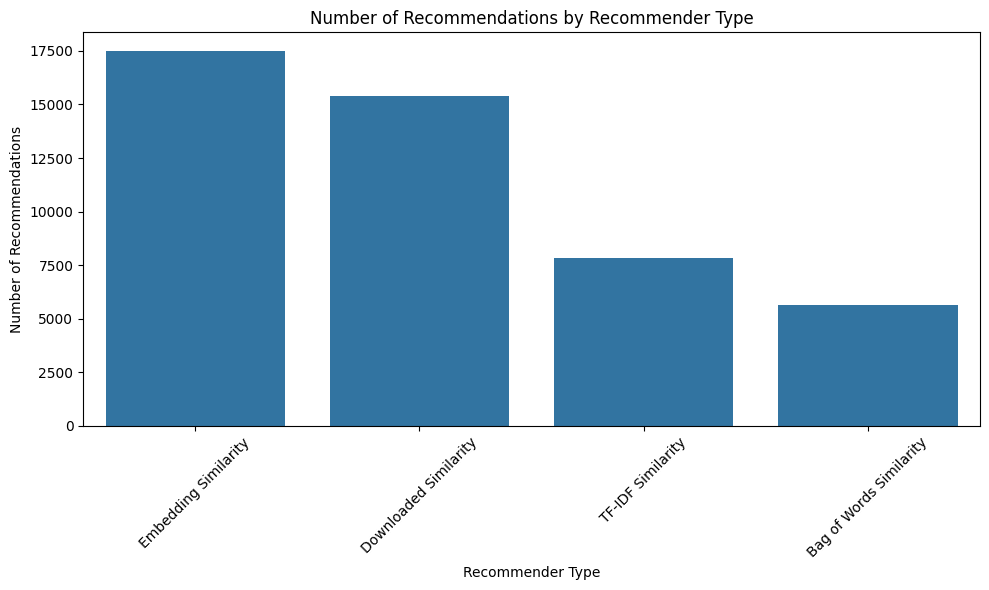

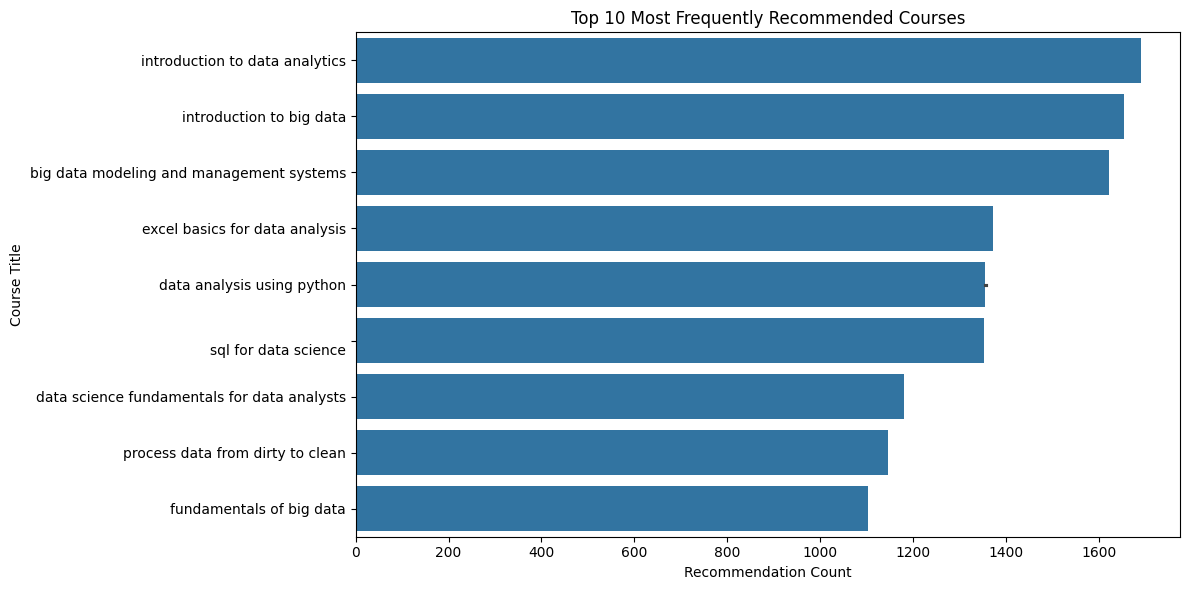

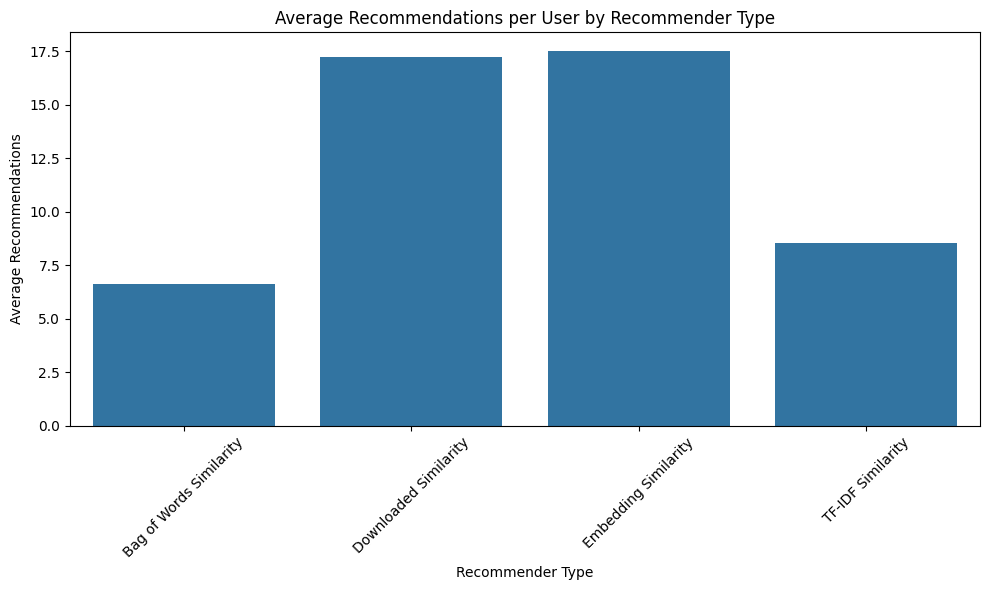

In [67]:
# calculate average number of recommendations per user
def analyze_recommendations_per_user(recommendations_df):
    # group by user and recommender type
    user_rec_counts = recommendations_df.groupby(['user', 'recommender']).size().reset_index(name='count')
    
    # calculate statistics by recommender type
    recommender_stats = user_rec_counts.groupby('recommender')['count'].agg(['mean', 'min', 'max', 'count']).reset_index()
    recommender_stats = recommender_stats.rename(columns={
        'mean': 'Avg Recommendations',
        'min': 'Min Recommendations',
        'max': 'Max Recommendations',
        'count': 'Users with Recommendations'
    })
    
    # average
    overall_avg = user_rec_counts['count'].mean()
    
    print(f"Overall average recommendations per user: {overall_avg:.2f}")
    print("\nBreakdown by recommender type:")
    print(recommender_stats.to_string(index=False))
    
    # count total unique users who received recommendations
    users_with_recs = user_rec_counts['user'].nunique()
    total_users = len(recommendations_df['user'].unique())
    
    print(f"\nUsers with at least one recommendation: {users_with_recs} out of {total_users} ({users_with_recs/total_users*100:.1f}%)")
    
    return recommender_stats, user_rec_counts

# find the most frequently recommended courses with titles
def get_top_recommended_courses(recommendations_df, course_content_df, top_n=10):
    # create a mapping of course IDs to titles
    course_titles = dict(zip(course_content_df['COURSE_ID'], course_content_df['TITLE']))
    
    # overall top courses
    overall_top_courses = recommendations_df['course'].value_counts().head(top_n)
    
    print(f"\nTop {top_n} Most Frequently Recommended Courses (Overall):")
    for i, (course_id, count) in enumerate(overall_top_courses.items(), 1):
        title = course_titles.get(course_id, "Title not available")
        print(f"{i}. {title}")
        print(f"   Course ID: {course_id}, Recommended {count} times")
    
    # top courses by recommender type
    print("\nTop courses by recommender type:")
    for recommender_type in recommendations_df['recommender'].unique():
        type_df = recommendations_df[recommendations_df['recommender'] == recommender_type]
        top_courses = type_df['course'].value_counts().head(5)
        
        print(f"\n{recommender_type} Recommender - Top 5 Courses:")
        for i, (course_id, count) in enumerate(top_courses.items(), 1):
            title = course_titles.get(course_id, "Title not available")
            print(f"{i}. {title} (Recommended {count} times)")
    
    # create a clean table for reporting
    top_courses_table = pd.DataFrame({
        'Course ID': overall_top_courses.index,
        'Course Title': [course_titles.get(cid, "Unknown") for cid in overall_top_courses.index],
        'Recommendation Count': overall_top_courses.values
    })
    
    # calculate percentage of total recommendations
    total_recs = len(recommendations_df)
    top_courses_table['Percentage'] = (top_courses_table['Recommendation Count'] / total_recs * 100).round(2)
    
    return top_courses_table

# compare recommender types
def compare_recommender_types(recommendations_df):
    # count recommendations by type
    type_counts = recommendations_df['recommender'].value_counts()
    
    # calculate average similarity score by type
    avg_scores = recommendations_df.groupby('recommender')['similarity_score'].mean().sort_values(ascending=False)
    
    print("\nRecommender Type Comparison:")
    print(f"Total recommendations: {len(recommendations_df)}")
    
    comparison_df = pd.DataFrame({
        'Recommender Type': type_counts.index,
        'Number of Recommendations': type_counts.values,
        'Percentage': (type_counts.values / type_counts.sum() * 100).round(2),
        'Avg Similarity Score': [avg_scores[rec_type] for rec_type in type_counts.index]
    })
    
    print(comparison_df.to_string(index=False))
    
    return comparison_df

# analyse similarity score distribution
def analyze_similarity_scores(recommendations_df):
    
    # summary statistics
    score_stats = recommendations_df.groupby('recommender')['similarity_score'].describe()
    print("\nSimilarity Score Statistics by Recommender Type:")
    print(score_stats)
    
    return score_stats

# run all analyses
recommender_stats, user_rec_counts = analyze_recommendations_per_user(recommendations_df)
top_courses_table = get_top_recommended_courses(recommendations_df, course_content_df)
recommender_comparison = compare_recommender_types(recommendations_df)
score_stats = analyze_similarity_scores(recommendations_df)

# create visualizations for the report
plt.figure(figsize=(10, 6))
sns.barplot(x='Recommender Type', y='Number of Recommendations', data=recommender_comparison)
plt.title('Number of Recommendations by Recommender Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# visualise top 10 courses
plt.figure(figsize=(12, 6))
sns.barplot(x='Recommendation Count', y='Course Title', data=top_courses_table)
plt.title('Top 10 Most Frequently Recommended Courses')
plt.tight_layout()
plt.show()

# visualise average recommendations per user by recommender type
plt.figure(figsize=(10, 6))
sns.barplot(x='recommender', y='Avg Recommendations', data=recommender_stats)
plt.title('Average Recommendations per User by Recommender Type')
plt.xlabel('Recommender Type')
plt.ylabel('Average Recommendations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

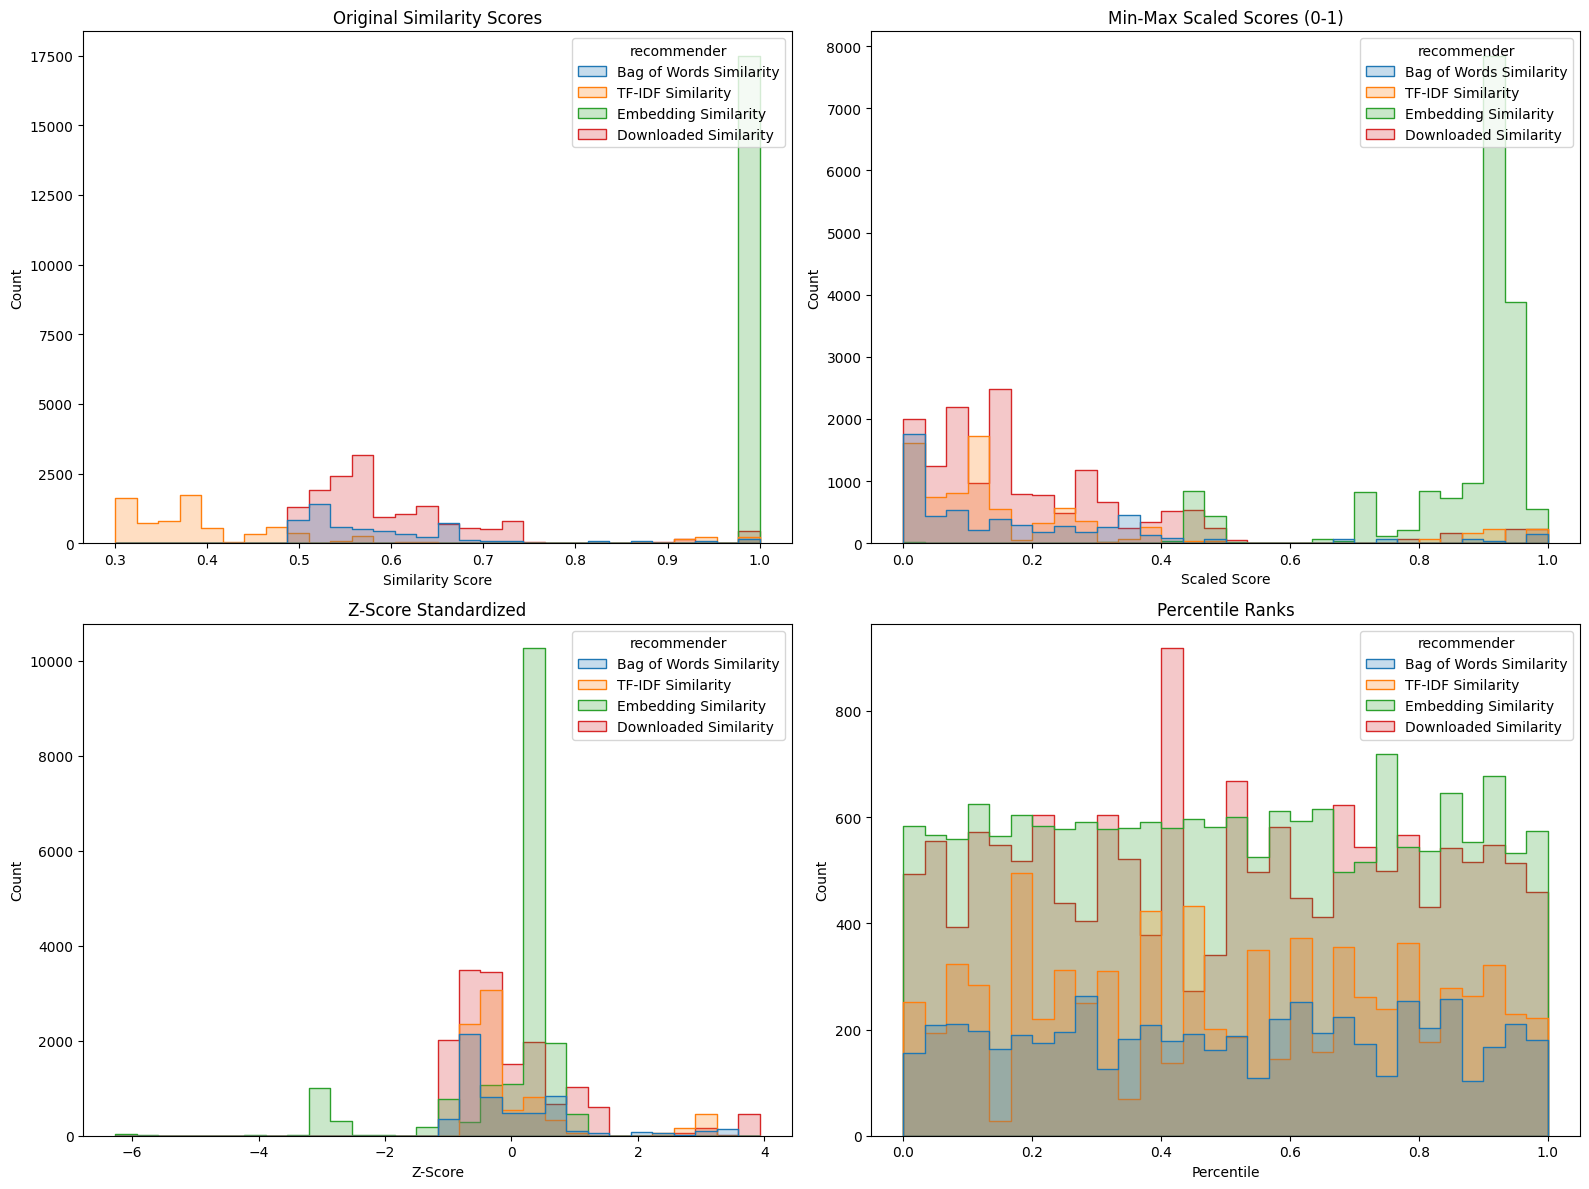


Average Scores by Recommender Type:
            recommender  similarity_score  min_max_score       z_score  percentile_rank
Bag of Words Similarity          0.595047       0.194701 -5.956547e-16         0.500088
  Downloaded Similarity          0.604120       0.207869 -1.160965e-15         0.500032
   Embedding Similarity          0.999868       0.866783 -3.630480e-13         0.500029
      TF-IDF Similarity          0.435728       0.193377  1.414452e-16         0.500064

Recommender Type Comparison with Scaled Scores:
       Recommender Type  Number of Recommendations  Percentage  Avg Original Score  Avg Min-Max Score  Avg Percentile
   Embedding Similarity                      17494       37.71            0.999868           0.866783        0.500029
  Downloaded Similarity                      15399       33.19            0.604120           0.207869        0.500032
      TF-IDF Similarity                       7846       16.91            0.435728           0.193377        0.500064
Ba

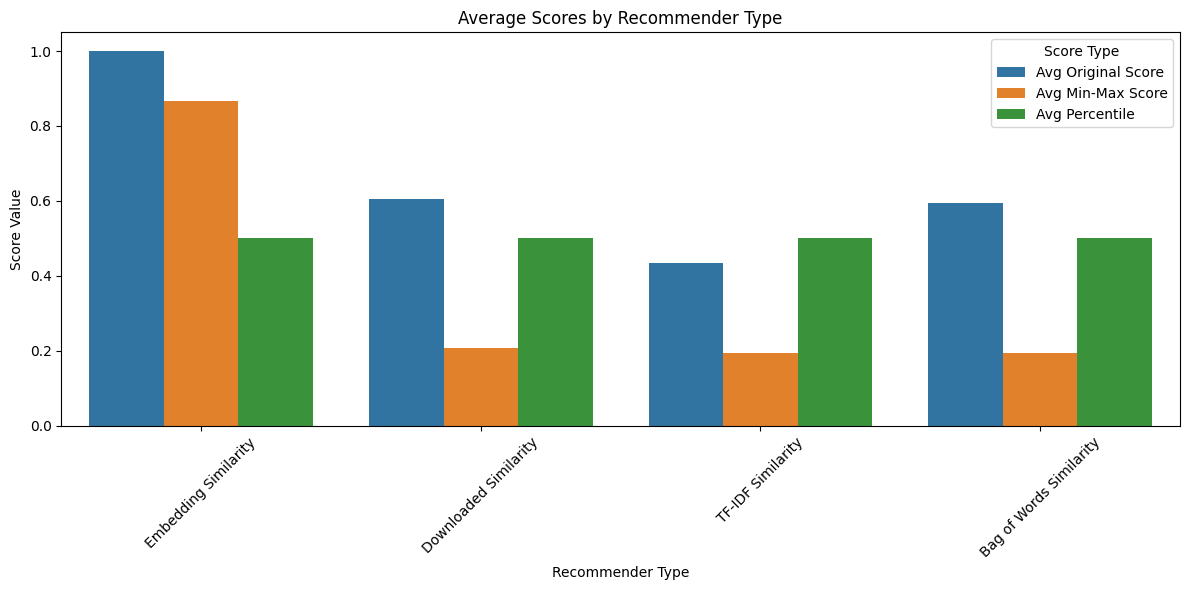

In [68]:
def scale_similarity_scores(recommendations_df):
    """
    Scale similarity scores to make them comparable across different recommender types.
    
    Methods:
    1. Min-Max scaling (to 0-1 range)
    2. Z-score standardization
    3. Percentile ranking
    """
    # create a copy to avoid modifying the original
    scaled_df = recommendations_df.copy()
    
    # min-max scaling (per recommender type)
    scaled_df['min_max_score'] = 0.0
    
    for recommender in scaled_df['recommender'].unique():
        mask = scaled_df['recommender'] == recommender
        scores = scaled_df.loc[mask, 'similarity_score']
        min_score = scores.min()
        max_score = scores.max()
        
        # Avoid division by zero
        if max_score > min_score:
            scaled_df.loc[mask, 'min_max_score'] = (scores - min_score) / (max_score - min_score)
        else:
            scaled_df.loc[mask, 'min_max_score'] = 1.0  # If all scores are the same
    
    # z-score standardization (per recommender type)
    scaled_df['z_score'] = 0.0
    
    for recommender in scaled_df['recommender'].unique():
        mask = scaled_df['recommender'] == recommender
        scores = scaled_df.loc[mask, 'similarity_score']
        mean = scores.mean()
        std = scores.std()
        
        # avoid division by zero
        if std > 0:
            scaled_df.loc[mask, 'z_score'] = (scores - mean) / std
        else:
            scaled_df.loc[mask, 'z_score'] = 0.0  # If all scores are the same
    
    # percentile ranking (per recommender type)
    scaled_df['percentile_rank'] = 0.0
    
    for recommender in scaled_df['recommender'].unique():
        mask = scaled_df['recommender'] == recommender
        scores = scaled_df.loc[mask, 'similarity_score']
        
        # calculate percentile ranks
        ranks = scores.rank(pct=True)
        scaled_df.loc[mask, 'percentile_rank'] = ranks
    
    return scaled_df

# apply scaling
scaled_recommendations = scale_similarity_scores(recommendations_df)

# visualise the scaled scores
def plot_scaled_scores(scaled_df):
    """Plot the original and scaled similarity scores for comparison."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # original scores
    sns.histplot(data=scaled_df, x='similarity_score', hue='recommender', 
                element='step', common_norm=False, bins=30, ax=axes[0, 0])
    axes[0, 0].set_title('Original Similarity Scores')
    axes[0, 0].set_xlabel('Similarity Score')
    
    # min-max scaled scores
    sns.histplot(data=scaled_df, x='min_max_score', hue='recommender', 
                element='step', common_norm=False, bins=30, ax=axes[0, 1])
    axes[0, 1].set_title('Min-Max Scaled Scores (0-1)')
    axes[0, 1].set_xlabel('Scaled Score')
    
    # z-score standardized
    sns.histplot(data=scaled_df, x='z_score', hue='recommender', 
                element='step', common_norm=False, bins=30, ax=axes[1, 0])
    axes[1, 0].set_title('Z-Score Standardized')
    axes[1, 0].set_xlabel('Z-Score')
    
    # percentile ranks
    sns.histplot(data=scaled_df, x='percentile_rank', hue='recommender', 
                element='step', common_norm=False, bins=30, ax=axes[1, 1])
    axes[1, 1].set_title('Percentile Ranks')
    axes[1, 1].set_xlabel('Percentile')
    
    plt.tight_layout()
    plt.show()
    
    # compare average scaled scores by recommender type
    avg_scaled = scaled_df.groupby('recommender')[
        ['similarity_score', 'min_max_score', 'z_score', 'percentile_rank']
    ].mean().reset_index()
    
    print("\nAverage Scores by Recommender Type:")
    print(avg_scaled.to_string(index=False))
    
    return avg_scaled

# plot the scaled scores
avg_scaled = plot_scaled_scores(scaled_recommendations)

# compare recommender types with scaled scores
def compare_with_scaled_scores(scaled_df):
    """Compare recommender types using the scaled scores."""
    # count recommendations by type
    type_counts = scaled_df['recommender'].value_counts()
    
    # calculate average scores by type
    avg_scores = scaled_df.groupby('recommender')[
        ['similarity_score', 'min_max_score', 'z_score', 'percentile_rank']
    ].mean()
    
    comparison_df = pd.DataFrame({
        'Recommender Type': type_counts.index,
        'Number of Recommendations': type_counts.values,
        'Percentage': (type_counts.values / type_counts.sum() * 100).round(2),
        'Avg Original Score': [avg_scores.loc[rec_type, 'similarity_score'] for rec_type in type_counts.index],
        'Avg Min-Max Score': [avg_scores.loc[rec_type, 'min_max_score'] for rec_type in type_counts.index],
        'Avg Percentile': [avg_scores.loc[rec_type, 'percentile_rank'] for rec_type in type_counts.index]
    })
    
    print("\nRecommender Type Comparison with Scaled Scores:")
    print(comparison_df.to_string(index=False))
    
    # visualise the comparison
    plt.figure(figsize=(12, 6))
    
    # create a melted dataframe for easier plotting
    plot_df = comparison_df.melt(
        id_vars=['Recommender Type'], 
        value_vars=['Avg Original Score', 'Avg Min-Max Score', 'Avg Percentile'],
        var_name='Score Type', 
        value_name='Score Value'
    )
    
    # plot the comparison
    sns.barplot(x='Recommender Type', y='Score Value', hue='Score Type', data=plot_df)
    plt.title('Average Scores by Recommender Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# compare with scaled scores
scaled_comparison = compare_with_scaled_scores(scaled_recommendations)